# Projet 3: Concevez une application au service de la santé publique

Open Food Facts est une association à but non lucratif composée de volontaires qui fournit une base de données de produits alimentaires qui répertorie les ingrédients, les allergènes, la composition nutritionnelle et toutes les informations présentes sur les étiquettes des aliments. 

Toute la base de données est publiée sous forme de données ouvertes (open data) qui peuvent être utilisées par tous et pour tous usages.

La base de données contient:
- des **informations générales**: code barre du produit, url du produit sur le site d'Open Food Facts, contributeur qui a ajouté le produit pour la première fois, date de l'ajout et de la modification d'un produit, le nom du produit, sa quantité, son image
- des informations sur le **type du produit**: marque, catégorie, label
- des informations sur sa **provenance**: origine, lieu de transformation, pays,villes et magasins où sont proposés les produits
- des informations sur le type d'**emballage** du produit
- des informations sur la **composition** du produit: ingrédients, additifs, allergènes, nutriments, vitamines
- des **scores**: empreinte carbonne, nutriscore (défini par la FSA et sa version adaptée au marché français), grade de nutrition (de A à E)

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :
- en **nutriments et aliments à favoriser** (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en **nutriments à limiter** (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation.

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Visualisation et chargement du dataset](#dataset)
3. [Mots qui apparaissent le plus souvent dans le nom des variables](#words)
4. [Autres variables](#misc)
5. [Sélection de variables pertinentes en lien avec le choix d'application](#selec_var)
6. [Doublons](#doublons)
7. [Harmonisation des champs](#harmonisation) 
8. [Gestion des valeurs aberrantes](#outliers)
9. [Gestion des valeurs manquantes](#nan)   

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np # pour l'algèbre linéaire
import pandas as pd # pour l'analyse de données
import collections # pour compter l'occurence de mots
from collections import Counter

import seaborn as sns # datavisualisation
import matplotlib.pyplot as plt # datavisualisation
from matplotlib.gridspec import GridSpec # visualisation sous forme de grille
from wordcloud import WordCloud # nuage de mots

In [2]:
#plt.rcParams.keys()

In [3]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

## Visualisation et chargement du dataset <a class="anchor" id="dataset"></a>

In [6]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t')

Lorsque l'on tente de charger directement le dataset, on obtient une erreur indiquant l'index des colonnes posant problème (type mixte). Afin de récupérer le nom des variables pour leur affecter un dtypes avant import, nous allons charger uniquement les 5 premières lignes et récupérer les colonnes (0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66):

In [7]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', nrows = 5)
#openfoodfacts

In [8]:
#liste_colonnes_pour_dtypes = [0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66]
#print(openfoodfacts.iloc[:,liste_colonnes_pour_dtypes].columns.tolist())

In [9]:
# Certaines colonnes ont des modalités de type différent, forçons le type en object
dtypes = {
    'code':object, 
    'abbreviated_product_name':object, 
    'packaging_text':object, 
    'origins':object,
    'origins_tags':object, 
    'origins_en':object, 
    'manufacturing_places':object,
    'manufacturing_places_tags':object, 
    'emb_codes':object, 
    'emb_codes_tags':object,
    'first_packaging_code_geo':object, 
    'cities_tags':object,
    'purchase_places':object,
    'allergens':object,
    'traces':object,
    'traces_tags':object, 
    'traces_en':object, 
    'ingredients_from_palm_oil_tags':object, 
    'ingredients_that_may_be_from_palm_oil_tags':object, 
    'brand_owner':object, 
    'ecoscore_grade_fr':object
}

In [10]:
# Chargement du dataset avec les bons dtypes
openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', dtype=dtypes)

Nous allons créer une fonction qui permettra de savoir si lors d'un import futur, les variables correspondent à celles chargées à l'origine. Si ce n'est pas le cas, il faudra analyser les nouvelles variables afin de définir si elles apportent une information supplémentaire et peut être adapter le script.

In [11]:
#print(openfoodfacts.columns.tolist())

In [12]:
def controle_des_colonnes(dataset):
    '''Fonction qui permet de vérifier que toutes les colonnes ont bien été importées parmi la liste des variables 
    importées lors de la phase de cleaning'''
    
    liste_colonnes = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                      'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 
                      'packaging', 'packaging_tags', 'packaging_text', 'brands', 'brands_tags', 'categories', 
                      'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 
                      'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 
                      'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 
                      'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 
                      'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 
                      'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 
                      'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 
                      'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 
                      'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 
                      'states', 'states_tags', 'states_en', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 
                      'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 
                      'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'energy-kj_100g', 
                      'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 
                      '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', 
                      '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', 
                      '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', 
                      '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                      'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', 
                      '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', 
                      '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 
                      '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', 
                      '-erucic-acid_100g', '-nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 
                      'carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', 
                      '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g', 'polyols_100g', 
                      'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 
                      'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 
                      'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 
                      'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 
                      'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 
                      'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 
                      'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 
                      'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 
                      'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g', 
                      'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 
                      'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 
                      'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 
                      'glycemic-index_100g', 'water-hardness_100g', 'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g', 
                      'inositol_100g', 'carnitine_100g']
    
    
    if dataset.columns.tolist() == liste_colonnes:
        print('Toutes les variables ont bien été chargées')
    
    else:
        print('Variable(s) non présente(s) dans le dataset:')
        print(set(liste_colonnes) - set(dataset.columns.tolist()))
        
        print('Variable(s) supplémentaires dans le dataset:')
        print(set(dataset.columns.tolist()) - set(liste_colonnes))

In [13]:
controle_des_colonnes(openfoodfacts)

Toutes les variables ont bien été chargées


In [14]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.9+ GB


In [15]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,...,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/00000000000003429145/l-casei,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene Lactobacidus casei), vitaminas (B6 y D).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000000000031/cacao,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0

Regardons à présent le nombre de lignes et colonnes du dataset.

In [16]:
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 187


Supprimons les variables composées à 100% de valeurs manquantes qui n'apportent aucune information et viennent alourdir le dataset.

In [17]:
# Liste des colonnes avec 100% de NaN
print([c for c in openfoodfacts.columns if (openfoodfacts[c].isnull().mean()*100 == 100)])

['cities', 'allergens_en', 'no_nutriments', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g', '-maltodextrins_100g']


In [18]:
# Suppression les colonnes avec 100% de données manquantes
openfoodfacts.dropna(how='all', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 148


In [19]:
def missing_values_all(dataframe):
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing / (dataframe.shape[0] * dataframe.shape[1]) * 100, 2)
    
    print(f'Nombre total de NaN du dataset: {missing} \n % total de NaN du dataset: {missing_percent}%')

In [20]:
missing_values_all(openfoodfacts)

Nombre total de NaN du dataset: 227465052 
 % total de NaN du dataset: 74.84%


## Mots qui apparaissent le plus souvent dans le nom des variables <a class="anchor" id="words"></a>

Dans un premier temps et afin de prendre connaissance avec les variables du jeu de données, récupérons les mots contenus dans le titre des variables qui reviennent le plus souvent.
Cette étape nous permettra de repérer une potentielle redondance entre les variables.

In [21]:
# Récupération des mots contenus dans les titres des colonnes (séparateur =  "_")
liste_mots_colonnes = [i.split('_') for i in openfoodfacts.columns] 

# Applatissement de la liste de listes
liste_mots_colonnes_flat = []

for item in liste_mots_colonnes:
    liste_mots_colonnes_flat += item

In [22]:
# J'affiche les 20 mots qui reviennent le plus dans les titres de colonnes
print(collections.Counter(liste_mots_colonnes_flat).most_common(20))

# J'enregistre tous les mots et le nombre associé dans une variable
most_common_columns_words = collections.Counter(liste_mots_colonnes_flat).most_common(len(liste_mots_colonnes_flat))

[('100g', 79), ('tags', 14), ('en', 8), ('url', 7), ('ingredients', 7), ('image', 6), ('packaging', 4), ('from', 4), ('palm', 4), ('oil', 4), ('name', 3), ('categories', 3), ('origins', 3), ('places', 3), ('labels', 3), ('countries', 3), ('traces', 3), ('additives', 3), ('n', 3), ('states', 3)]


In [23]:
# Passage sous dataframe afin de pouvoir visualiser les données sous forme de graphique (nb occurences >= 6)
most_common_columns_words = pd.DataFrame(most_common_columns_words, 
                                 columns = ['Mots', 'Nombre d\'occurences']).sort_values(by = 'Nombre d\'occurences', 
                                                                                         ascending=False)

most_common_columns_words = most_common_columns_words[most_common_columns_words["Nombre d\'occurences"] >= 6]

In [24]:
def etiquette_h(ax):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot horizontal.
    Arguments:
    ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes du plot à annoter."""
    
    for p in ax.patches:
        etiquette = '{:,.0f}'.format(p.get_width())
        width, height = p.get_width(),p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(etiquette,(x,y))

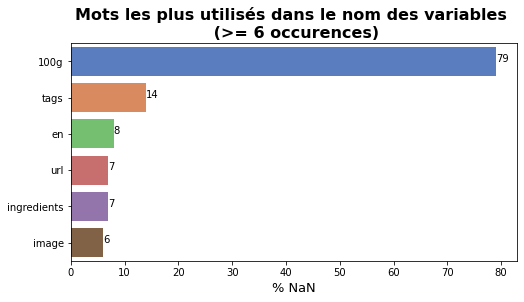

In [25]:
# Visualisation sous forme de barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(y = 'Mots', x = 'Nombre d\'occurences', data = most_common_columns_words, palette = 'muted')
plt.title("Mots les plus utilisés dans le nom des variables \n (>= 6 occurences)")
plt.ylabel("")
plt.xlabel("% NaN")
etiquette_h(ax);

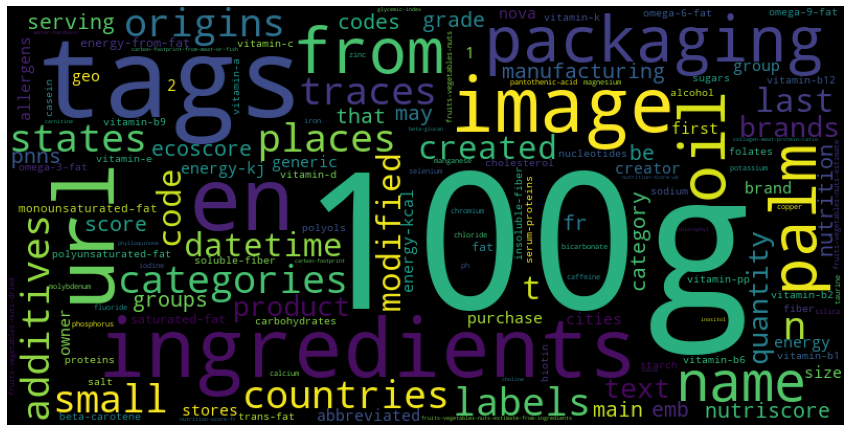

In [26]:
# Création d'un nuage de mots

# Conversion de la liste en dictionnaire valeurs / occurences
word_cloud_dict = Counter(liste_mots_colonnes_flat)
wordcloud = WordCloud(width = 800, height = 400).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off");

Nous allons analyser les variables qui ont le même préfixe afin de commencer à supprimer les variables qui apportent la même information. Ensuite, nous passerons en revue les autres variables afin de savoir lesquelles sélectionner dans notre dataset final. Lors de la sélection des variables, nous gardons en tête notre idée d'application. Ce passage en revue des différents variables va nous permettre de mieux connaitre le jeu de données et d'affiner notre projet en lien avec l'alimentation.

### 100g

Les variables qui se terminent par _100g correspondent à la quantité de nutriments (en g ou kj pour l'énergie) pour 100g ou 100 ml de produit. Logiquement ces variables devraient être de type float.

In [27]:
# Liste des colonnes qui se terminent par _100g
col_100g = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_100g')].columns.tolist()
print(col_100g)

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'sele

In [28]:
# On downcast les variables en float32 pour réduire la mémoire
for col in col_100g:
    openfoodfacts[col] = openfoodfacts[col].astype('float32')

In [29]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 148 entries, code to carnitine_100g
dtypes: float32(79), float64(7), int64(2), object(60)
memory usage: 1.7+ GB


In [30]:
# Dtypes des variables qui se terminent par _100g et qui ne sont pas de type float
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_100g)].select_dtypes(exclude = ['float32']).dtypes

Series([], dtype: object)

Toutes ces variables sont bien au format float. En regardant la liste des colonnes, on peut se demander si les variables energy-kj_100g et energy_100g apportent la même information.

In [31]:
openfoodfacts[openfoodfacts[['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].notnull().all(1)][
    ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']].head()

,energy-kj_100g,energy-kcal_100g,energy_100g
4,685.799988,163.899994,685.799988
417,2318.000000,561.000000,2318.000000
419,1104.000000,268.000000,1104.000000
790,442.000000,1852.000000,442.000000
863,1926.000000,460.000000,1926.000000


Les colonnes energy-kj_100g et energy_100g semblent être redondantes. Regardons la proportion de NaN.

In [32]:
print(f"% de NaN de la variable energy-kj_100g: {round(openfoodfacts['energy-kj_100g'].isna().mean(),4)*100}%")
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy-kj_100g: 92.7%
% de NaN de la variable energy_100g: 20.66%


La variables energy_100g comporte bien moins de valeurs manquantes que energy-kj_100g. Nous allons remplir les NaN de energy_100g avec les éventuelles  valeurs renseignées de energy-kj_100g puis supprimer la colonne energy-kj_100g.

In [33]:
# Pour les NaN de energy_100g, je complète avec energy-kj_100g sinon je laisse tel quel
openfoodfacts['energy_100g'] = np.where(openfoodfacts['energy_100g'].isnull(), 
                                        openfoodfacts['energy-kj_100g'], 
                                        openfoodfacts['energy_100g'])

In [34]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 20.66%


La variable energy-kj_100g ne semble pas avoir diminué le taux de NaN de energy_100g, nous pouvons la supprimer.

In [35]:
openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')
openfoodfacts.shape

<ipython-input-35-112d0e192dab>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  openfoodfacts = openfoodfacts.drop('energy-kj_100g', 'columns')


(2053679, 147)

### tags

Les variables qui se terminent par _tags sont des variables qualitatives (packaging, marques, catégories etc). Elles doivent être de type "object".

In [36]:
# Liste des colonnes qui se terminent par _tags
col_tags = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_tags')].columns.tolist()
print(col_tags)

['packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'cities_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'states_tags']


In [37]:
# On cast les variables en str
for col in col_tags:
    openfoodfacts[col] = openfoodfacts[col].astype("object")

In [38]:
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_tags)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

Toutes ces variables ont bien le dtype objet. A partir du préfixe des variables se terminant par _tags, tentons de récupérer les variables associées afin de s'assurer qu'elles ne sont pas redondantes. 

In [39]:
# Pour chaque colonne se terminant par _tags, je supprime cette mention pour n'avoir que le préfixe
liste_col_tags_prefixe = [i.replace('_tags', '') for i in openfoodfacts.iloc[
    :,openfoodfacts.columns.isin(col_tags)].columns.unique().tolist()]

print(f'Préfixes des colonnes se terminant par _tags: {liste_col_tags_prefixe}')

Préfixes des colonnes se terminant par _tags: ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'cities', 'countries', 'traces', 'additives', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'states']


In [40]:
# Fusion des 2 listes + tri par ordre alphabétique
liste_col_tags = liste_col_tags_prefixe + col_tags
liste_col_tags.sort()

In [41]:
print(f'Colonnes + colonnes associées _tags:\n\n {liste_col_tags}')

Colonnes + colonnes associées _tags:

 ['additives', 'additives_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'countries', 'countries_tags', 'emb_codes', 'emb_codes_tags', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'labels', 'labels_tags', 'manufacturing_places', 'manufacturing_places_tags', 'origins', 'origins_tags', 'packaging', 'packaging_tags', 'states', 'states_tags', 'traces', 'traces_tags']


Automatisation des étapes précédentes.

In [42]:
def liste_col_endswith(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_ends_keyword = dataframe.iloc[:,(dataframe.columns.str.endswith(
    keyword))].columns.unique().tolist()
    
    liste_col_keyword = liste_col_keyword_prefixe + liste_col_ends_keyword
    liste_col_keyword.sort()
    
    return liste_col_keyword

In [43]:
liste_col_tags = liste_col_endswith(openfoodfacts, 'tags')

In [44]:
def describe_variables_light(data):
    '''Fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count, 
                                      percent_count,missing, percent_missing]], 
                                    columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                               '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN']))
        
    return df.reset_index(drop = True)

In [45]:
describe_variables_light(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging,object,"barquette,plastique",2053679,57066,2.78,315935,15.38,1737744,84.62
1,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62
2,brands,object,endives,2053679,183520,8.94,1050597,51.16,1003082,48.84
3,brands_tags,object,endives,2053679,141427,6.89,1050528,51.15,1003151,48.85
4,categories,object,"Epicerie, Condiments, Sauces, Moutardes",2053679,117610,5.73,945149,46.02,1108530,53.98
5,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98
6,origins,object,Spain,2053679,14023,0.68,88290,4.30,1965389,95.70
7,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71
8,manufacturing_places,object,bénivay-ollon,2053679,28901,1.41,128424,6.25,1925255,93.75
9,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75


In [46]:
def completion_distinct_plots(data):
    ''' fonction qui prend un dataframe en entrée et retourne 2 diagrammes en barres représentant le pourcentage 
    de données manquantes et le pourcentage de données distinctes du dataset. Cette fonction nécessite que
    soit chargée auparavant la fonction describe_variables '''   
    
    # Initialisation de la grille avec 1 ligne et 2 colonnes
    fig = plt.figure(figsize=(15,7), constrained_layout=True)
    gs = GridSpec(nrows=1, ncols=2, figure=fig)

    # Premier graphique
    ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
    ax1 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables_light(data), palette = 'muted')
    plt.title("% NaN")
    plt.ylabel("")
    plt.xlabel("% NaN")
    etiquette_h(ax1)
        

# Deuxième graphique
    ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
    ax2 = sns.barplot(y = 'Variable name', x = '% distinct', data = describe_variables_light(data), palette = 'muted')
    plt.title("% valeurs distinctes")
    plt.ylabel("")
    plt.xlabel("% distinct")
    etiquette_h(ax2);

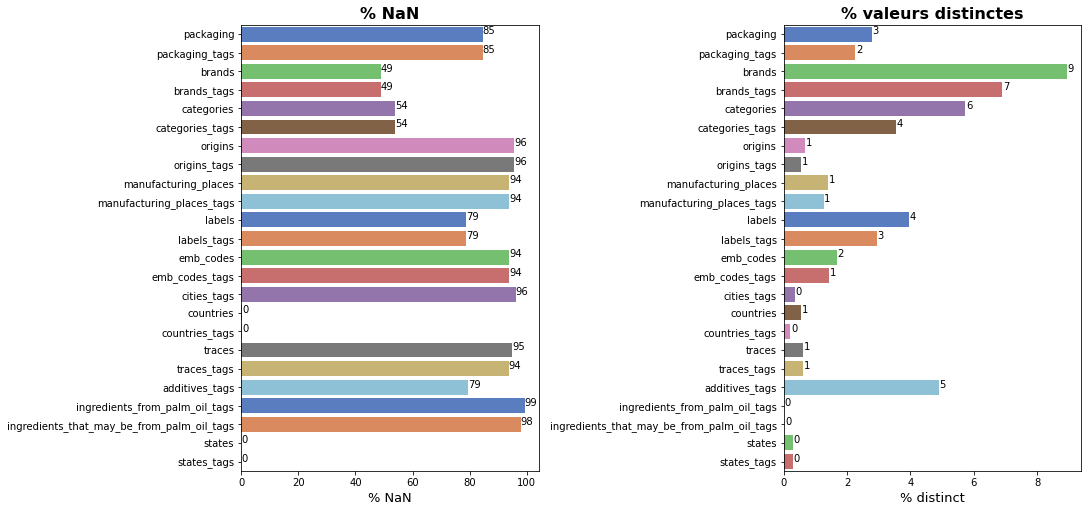

In [47]:
completion_distinct_plots(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

Nous remarquons que les variables se terminant par _tags comportent souvent le même % de NaN que la variable associée mais le % de valeurs distinctes est quant à lui inférieur. Il semble être plus intéressant de conserver les variables se terminant par _tags et de supprimer les variables associées afin d'éviter la redondance d'information. De plus le site openfoodfacts nous indique que les variables _tags sont normalisées. Regardons quelques exemples avant de supprimer toutes les variables associées à celles se terminant par _tags.

In [48]:
openfoodfacts[~openfoodfacts['brands'].isnull()][['brands', 'brands_tags']].sample(10)

,brands,brands_tags
986801,Biolo'Klock,biolo-klock
481678,Wild Oats Marketing Llc,wild-oats-marketing-llc
1778248,Mamía,mamia
1006936,Bio Village,bio-village
1973731,Maizena,maizena
964482,Cite marine,cite-marine
1988668,Bertolli,bertolli
1817320,manzanares,manzanares
627803,lidl,lidl
736751,"Bledina, Blediner","bledina,blediner"


In [49]:
openfoodfacts[~openfoodfacts['categories'].isnull()][['categories', 'categories_tags']].sample(10)

,categories,categories_tags
873589,"Boissons, Boissons alcoolisées, Vins, Vins français, Vins effervescents, Champagnes, Champagnes français, Champagnes bruts","en:beverages,en:alcoholic-beverages,en:wines,en:wines-from-france,en:sparkling-wines,en:champagnes,en:french-champagnes,fr:champagnes-bruts"
489052,"Snacks, Sweet snacks, Biscuits and cakes, Biscuits","en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:biscuits"
1191007,"Plant-based foods and beverages, Plant-based foods, Flours, de:Weizenmehl, de:Weizenmehl Type 405, en:wheat-flours","en:plant-based-foods-and-beverages,en:plant-based-foods,en:cereals-and-potatoes,en:cereals-and-their-products,en:flours,en:cereal-flours,en:wheat-flours,de:weizenmehl,de:weizenmehl-type-405"
1342669,"Plant-based foods and beverages, Plant-based foods, Spreads, Fats, Salted spreads, Spreadable fats, Olive tree products, Plant-based spreads, Vegetable fats, Margarines","en:plant-based-foods-and-beverages,en:plant-based-foods,en:fats,en:spreads,en:salted-spreads,en:spreadable-fats,en:vegetable-fats,en:olive-tree-products,en:plant-based-spreads,en:margarines"
252137,Snacks,en:snacks
854567,"Plats préparés, Plats préparés au poisson, Bouillabaisses","en:meals,en:meals-with-fish,fr:bouillabaisses"
1278673,"Pflanzliche Lebensmittel und Getränke, Getränke, Pflanzliche Lebensmittel, Getreide und Kartoffeln, Getreideprodukte, Pflanzliche Getränke, Milchersatz, Pflanzenmilch, Getreidemilch, Weizenmilch, Dinkelmilch","en:plant-based-foods-and-beverages,en:beverages,en:plant-based-foods,en:cereals-and-potatoes,en:cereals-and-their-products,en:plant-based-beverages,en:milk-substitute,en:plant-milks,en:cereal-milks,en:wheat-milks,en:spelt-milks"
211052,"Plant-based foods and beverages, Plant-based foods, Groceries, Fruits and vegetables based foods, Vegetables based foods, Tomatoes and their products, Sauces, Tomatoes, Tomato sauces","en:plant-based-foods-and-beverages,en:plant-based-foods,en:groceries,en:fruits-and-vegetables-based-foods,en:vegetables-based-foods,en:tomatoes-and-their-products,en:sauces,en:tomatoes,en:tomato-sauces"
10257,"Biscuits and cakes, Cakes, Cooking helpers, Dessert mixes, Pastry helpers, Cake mixes","en:biscuits-and-cakes,en:cooking-helpers,en:cakes,en:dessert-mixes,en:pastry-helpers,en:cake-mixes"
1282143,"Pflanzliche Lebensmittel und Getränke, Pflanzliche Lebensmittel, Brotaufstriche, Pflanzliche Brotaufstriche","en:plant-based-foods-and-beverages,en:plant-based-foods,en:spreads,en:plant-based-spreads"


In [50]:
openfoodfacts[~openfoodfacts['labels'].isnull()][['labels', 'labels_tags']].sample(10)

,labels,labels_tags
1390265,"Low or no salt,No added salt","en:low-or-no-salt,en:no-added-salt"
1387354,en:gluten-free,en:no-gluten
453912,Organic,en:organic
682956,Rainforest Alliance,en:rainforest-alliance
632011,Nutriscore,en:nutriscore
609584,"Viande Française, Volaille Française, Label Rouge","en:french-meat,en:french-poultry,fr:label-rouge"
750371,Fabriqué en France,en:made-in-france
1849406,"Vegetariano,Vegano,Sin aceite de palma","en:vegetarian,en:vegan,en:palm-oil-free"
1875012,"Nutriscore, Nutriscore A","en:nutriscore,en:nutriscore-grade-a"
1157131,"IZBRANA KAKOVOST Slovenija, BREZ GSO","sl:brez-gso,sl:izbrana-kakovost-slovenija"


Les variables semblent bien redondantes entre elles. Nous remarquons également que les variables se terminant par _tags semblent être le plus souvent traduites en anglais. Nous décidons de garder ces dernières.

In [51]:
liste_col_suppr = openfoodfacts.iloc[:,(openfoodfacts.columns.isin(liste_col_tags)) & 
                                        (~openfoodfacts.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'countries', 'traces', 'states']


In [52]:
# Suppression des variables sans suffixe _tags
openfoodfacts_tags = openfoodfacts.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_tags.shape[0]}\nNombre de variables: {openfoodfacts_tags.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 137


### en

La documentation nous indique que ces variables sont la traduction des variables _tags dans la langue indiquée. Elles doivent être de type "object".

In [53]:
# Liste des colonnes qui se terminent par _en
col_en = openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.str.endswith('_en')].columns.tolist()
print(col_en)

['categories_en', 'origins_en', 'labels_en', 'countries_en', 'traces_en', 'additives_en', 'states_en', 'main_category_en']


In [54]:
# On cast les variables en str
for col in col_en:
    openfoodfacts_tags[col] = openfoodfacts_tags[col].astype("object")

In [55]:
openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(col_en)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

In [56]:
print(liste_col_endswith(openfoodfacts_tags, 'en'))

['additives', 'additives_en', 'categories', 'categories_en', 'countries', 'countries_en', 'labels', 'labels_en', 'main_category', 'main_category_en', 'origins', 'origins_en', 'states', 'states_en', 'traces', 'traces_en']


On retrouve dans cette liste les préfixes des variables qui se terminent par _tags. Lorsque l'on applique la fonction précédente on ne récupère que le préfixe et la variable associée. Il faudrait en fait récupérer tous les préfixes et regarder les variables associées: _tags, _en etc. Améliorons la fonction.

In [57]:
def liste_col_prefixe(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_select = dataframe.iloc[:, dataframe.columns.str.startswith(
        tuple(liste_col_keyword_prefixe))].columns.unique().tolist()
    
    liste_col_select.sort()
                                      
    return dataframe.iloc[:,dataframe.columns.isin(liste_col_select)].columns

In [58]:
liste_col_en = liste_col_prefixe(openfoodfacts_tags, 'en')

In [59]:
describe_variables_light(openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(liste_col_en)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053679,72803,3.55,945141,46.02,1108538,53.98
1,categories_en,object,"Groceries,Condiments,Sauces,Mustards",2053679,72800,3.54,945141,46.02,1108538,53.98
2,origins_tags,object,en:spain,2053679,11428,0.56,88160,4.29,1965519,95.71
3,origins_en,object,Spain,2053679,11389,0.55,88160,4.29,1965519,95.71
4,labels_tags,object,fr:delois-france,2053679,60380,2.94,438458,21.35,1615221,78.65
5,labels_en,object,fr:delois-france,2053679,60362,2.94,438458,21.35,1615221,78.65
6,countries_tags,object,en:france,2053679,4403,0.21,2047488,99.70,6191,0.30
7,countries_en,object,France,2053679,4403,0.21,2047488,99.70,6191,0.30
8,traces_tags,object,"en:eggs,en:milk",2053679,12766,0.62,129529,6.31,1924150,93.69
9,traces_en,object,"Eggs,Milk",2053679,12766,0.62,129529,6.31,1924150,93.69


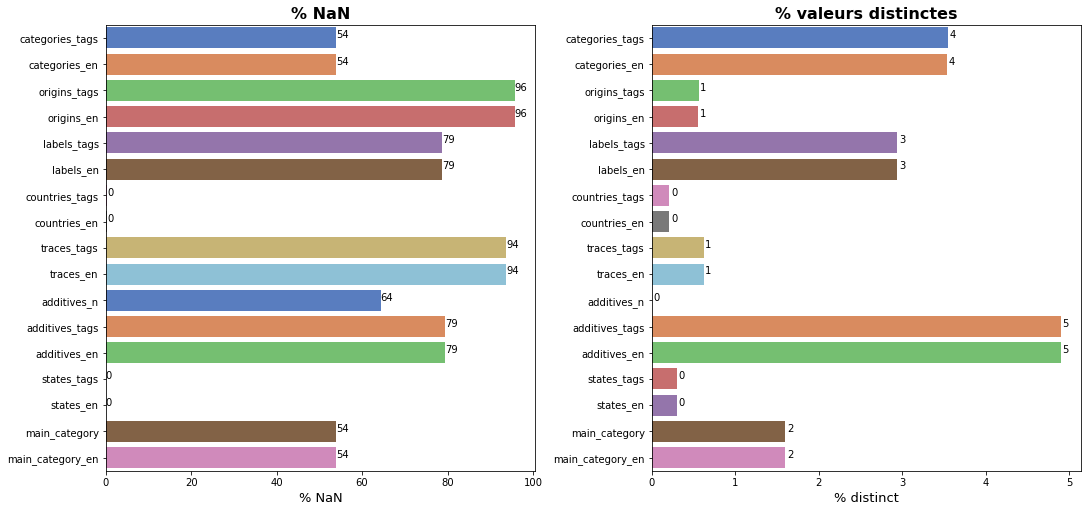

In [60]:
completion_distinct_plots(openfoodfacts_tags.iloc[:,openfoodfacts_tags.columns.isin(liste_col_en)])

Nous remarquons que les variables ayant le même préfixe comportent le même % de NaN et de valeurs distinctes. Comme nous avons déjà précedemment supprimé les variables sans suffixe, il nous reste les variables se terminant par _tags et _en. Nous avons donc le choix de conserver soit l'une soit l'autre. Vérifions juste un exemple avant de choisir quelles variables supprimer.

In [61]:
openfoodfacts_tags[~openfoodfacts_tags['categories_tags'].isnull()][['categories_tags', 'categories_en']].sample(10)

,categories_tags,categories_en
662898,"en:meats,en:prepared-meats,en:hams,en:cured-ham,en:dried-hams","Meats,Prepared meats,Hams,Cured ham,Dried hams"
1963752,"en:groceries,en:sauces,en:mayonnaises,en:light-mayonnaises","Groceries,Sauces,Mayonnaises,Light mayonnaises"
788673,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:cereals-and-potatoes,en:cereals-and-their-products,en:puffed-cereal-cakes,en:puffed-corn-cakes","Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Cereals and their products,Puffed cereal cakes,Puffed corn cakes"
816308,"en:snacks,en:salty-snacks,en:appetizers,en:crackers","Snacks,Salty snacks,Appetizers,Crackers"
995302,"en:plant-based-foods-and-beverages,en:beverages,en:plant-based-foods,en:fruits-and-vegetables-based-foods,en:fruits-based-foods,en:plant-based-beverages,en:fruit-based-beverages,en:fruits,en:juices-and-nectars,en:tropical-fruits,en:fruit-juices,en:concentrated-fruit-juices,en:pineapple,en:pineapple-juices,en:concentrated-pineapple-juices,fr:alimentos-y-bebidas-de-origen-vegetal,fr:bebidas,fr:bebidas-a-base-de-frutas,fr:bebidas-de-origen-vegetal,fr:zumos-de-frutas,fr:zumos-de-pina,fr:zumos-y-nectares","Plant-based foods and beverages,Beverages,Plant-based foods,Fruits and vegetables based foods,Fruits based foods,Plant-based beverages,Fruit-based beverages,Fruits,Juices and nectars,Tropical fruits,Fruit juices,Concentrated fruit juices,Pineapple,Pineapple juices,Concentrated pineapple juices,fr:alimentos-y-bebidas-de-origen-vegetal,fr:bebidas,fr:bebidas-a-base-de-frutas,fr:bebidas-de-origen-vegetal,fr:zumos-de-frutas,fr:zumos-de-pina,fr:zumos-y-nectares"
1701592,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:meals,en:plant-based-meals","Plant-based foods and beverages,Plant-based foods,Meals,Plant-based meals"
515607,en:snacks,Snacks
788064,"en:desserts,en:non-dairy-desserts,en:soy-desserts,en:flavoured-soy-dessert,en:vanilla-soy-desserts","Desserts,Non-dairy desserts,Soy desserts,Flavoured soy dessert,Vanilla soy desserts"
1848944,"en:biscuits-and-cakes,en:cakes","Biscuits and cakes,Cakes"
34634,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:cereals-and-potatoes,en:cereals-and-their-products","Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Cereals and their products"


Les modalités étant plus lisibles et harmonisées dans les colonnes se terminant par _en, supprimons les colonnes _tags.

In [62]:
liste_col_suppr = openfoodfacts_tags.iloc[:,(openfoodfacts_tags.columns.isin(liste_col_en)) & 
                                        (openfoodfacts_tags.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['categories_tags', 'origins_tags', 'labels_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'states_tags']


In [63]:
# Suppression des variables avec suffixe _tags
openfoodfacts_en = openfoodfacts_tags.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 130


### url / image

Ces variables indiquent les urls et les images des produits et n'apportent aucune information. Supprimons les.

In [64]:
liste_col_url = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains('url|image')].columns.unique().tolist()
print(f"Liste des variables url à supprimer: \n\n {liste_col_url}")

Liste des variables url à supprimer: 

 ['url', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']


In [65]:
# Suppression des variables contenant les mot url ou image
openfoodfacts_en.drop(liste_col_url, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 123


### ingredients

In [66]:
def check_redundancy(dataframe, keyword):
    ''' Fonction qui renseigne sur les principales statistiques des variables contenant le mot saisi en entrée.'''
    liste = dataframe.iloc[:,dataframe.columns.str.contains(keyword)].columns.unique().tolist()
    describe = describe_variables_light(dataframe[liste])
    return describe

In [67]:
def modalities_no_NaN(dataframe, keyword):
    ''' Fonction qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    liste_col = check_redundancy(dataframe, keyword)['Variable name'].tolist()
    return dataframe[dataframe[liste_col].notnull().all(1)][liste_col].sample(5)

In [68]:
def check_redundancy_steps(dataframe, mot_clef):
    ''' Fonction qui renvoie 2 dataframes: 
    tab_desc qui renseigne sur les principales  statistiques des variables contenant le mot saisi en entrée
    tab_modalities qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    tab_desc = check_redundancy(dataframe, mot_clef)
    tab_modalities = modalities_no_NaN(dataframe, mot_clef)
    return tab_desc, tab_modalities

In [69]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'ingredients')

In [70]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,ingredients_text,object,"Leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene Lactobacidus casei), vitaminas (B6 y D).",2053679,616705,30.03,732671,35.68,1321008,64.32
1,ingredients_from_palm_oil_n,float64,0.0,2053679,4,0.00,732673,35.68,1321006,64.32
2,ingredients_from_palm_oil_tags,object,huile-de-palme,2053679,16,0.00,14505,0.71,2039174,99.29
3,ingredients_that_may_be_from_palm_oil_n,float64,0.0,2053679,7,0.00,732673,35.68,1321006,64.32
4,ingredients_that_may_be_from_palm_oil_tags,object,"e481-stearoyl-2-lactylate-de-sodium,e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras,e472b-ester-diacetyl-lactique-de-mono-et-diglycerides-d-acides-gras",2053679,350,0.02,43295,2.11,2010384,97.89
5,fruits-vegetables-nuts-estimate-from-ingredients_100g,float32,0.0,2053679,7644,0.37,731230,35.61,1322449,64.39


In [71]:
tab_modalities

,ingredients_text,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,fruits-vegetables-nuts-estimate-from-ingredients_100g
970971,"Farine de blé, oeufs, beurre 9%&quot;, eau, sucre, levure, gluten de blé, sel, émulsifiants RE E471-E472e, arôme fleur d'oranger 0,3%&quot;, arôme naturel de citrons 0,1%, agent de traitement de la farine E300, farine de blé malté. Décor: Sucre perlé enrobé (sucre, huile de palme), oeufs. &quot;pourcentages exprimés sur le produit fini.",1.0,huile-de-palme,1.0,e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras,0.000000
1025403,"Chocolat au _lait_ belge (55 %) (sucre, beurre de cacao, _lait_ entier en poudre, pâte de cacao, émulsifiant : lécithines de _soja_, extrait de vanille), farine d'avoine sans gluten, sucre, margarine (huile de palme, huile de colza, eau, sel, émulsifiant : mono - et diglycérides d'acides gras, correcteur d'acidité : acide citrique), farine de maïs, farine de _soja_, sirop de sucre inverti, eau, poudre à lever : carbonates de sodium, arôme naturel, sel.",1.0,huile-de-palme,1.0,e471-mono-et-diglycerides-d-acides-gras-alimentaires,0.000000
932060,"Farine de _blé_, sirop de glucose-fructose, sucre, huiles végétales (palme, colza, tournesol) en proportion variable, fruits des bois (myrtille, mûre) 5 %, sirop de sucre inverti, agent épaississant : pectine, poudres à lever : E450i et E500ii, sel, conservateurs : E202 et E282, arômes, protéine du _lait_, correcteurs d'acidité : E330, E332 et E333, émulsifiants : lécithine de _soja_, lécithine de tournesol et E471, sucre du _lait_, colorant E160a.",1.0,huile-de-palme,2.0,"e471-mono-et-diglycerides-d-acides-gras-alimentaires,e160a-beta-carotene",10.000000
282116,"_Œufs_ durs de poules élevées en plein air (27 %) • Farine de blé contient _Gluten_ (avec Farine de blé, Carbonate de calcium, Fer, Niacine, Thiamine) • Tomates mûries sur pied (19 %) • Eau • Pétales de blé malté (contient _Gluten_) • Huile de colza • Sucre • Fécule de maïs, Son de blé (contient _Gluten_) • Vinaigre • Beurre (_Lait_) • Sel • Levure (Levure • Levure enrichie en vitamine D) • Farine d'orge malté (contient Gluten) • Jaune d'_œufs_ de poules élevées en plein air pasteurisés • Ciboulette • _Gluten_ de blé • Émulsifiant: E471 , E472e • Farine de blé malté (contient _Gluten_) • Graines de _moutarde_ noire • Fibres d'agrumes • Huile de colza pressée à froid • _Œufs_ de poules élevées en plein air pasteurisés • Poivre noir concassé • Dextrose • : Épaississant : Pectine • Jus de citron concentré • Agent de traitement de la farine : Acide ascorbique • Farine de moutarde • Huile de palme • Graisse de palme • Amidon de blé (contient _Gluten_).",1.0,huile-de-palme,2.0,"e471-mono-et-diglycerides-d-acides-gras-alimentaires,e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras",0.666667
1014093,"Semoule de blé, eau, huile de tournesol, pâte de datte 5.7%, farine de blé, margarine (huiles et graisses raffinées (palme, colza), eau, ěmulsifiants (E322, E471), sel, sucre, acidifiant (E330), arômes naturels, colorant (È160a)), sucre, arôme vanille (contient blé), poudres à lever (E450, È500, amidon de blé), cannelle, sel, conservateurs (E200, E282), stabilisant : E420. Frit dans de l'huile de tournesol Trempé dans du sirop (sucre, eau, sirop de glucose (contient sulfites),. jus de citron (contient sulfites)). Finition : graines de sésame. Prěsence possible de noyau de datte. Fabriqué dans un atelier utilisant : amande arachide, lait, noisette, œuf, pistache, soja",1.0,huile-de-palme,2.0,"e471-mono-et-diglycerides-d-acides-gras-alimentaires,e160a-beta-carotene",5.700000


Nous pouvons remarquer que la variable ingredients_text contient un grand nombre de modalités et 64.32% de valeurs manquantes. 

Nous pouvons également voir que 4 variables comportent la mention palm_oil dont 2 variables qui se terminent par _n indiquent le nombre d'ingrédients contenant de l'huile de palme. 

Les 2 variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags ont un pourcentage très élevé de valeurs manquantes et semblent redondantes avec les variables numériques, qui si supérieures à 0, indiquent la présence d'huile de palme ou assimilé. Nous décidons de les supprimer.

In [72]:
# Suppression des variables ingredients_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_tags
openfoodfacts_en.drop(['ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags'],
                        axis = 'columns',
                        inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 121


## Autres variables <a class="anchor" id="misc"></a>

La nomenclature des variables nous donne d'autres informations. Elle se trouve à l'adresse: https://static.openfoodfacts.org/data/data-fields.txt

### Variables de localisation <a class="anchor" id="localisation"></a>

#### places

In [73]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'places')

In [74]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,manufacturing_places_tags,object,benivay-ollon,2053679,25973,1.26,128364,6.25,1925315,93.75
1,purchase_places,object,France,2053679,11361,0.55,161431,7.86,1892248,92.14


In [75]:
tab_modalities

,manufacturing_places_tags,purchase_places
1609129,"estrada-guimaraes,459-2o-distrito,costa-da-miraguaia-cep-95500-000-santo-antonio-da-patrulha-rs",Brasil
1369648,united-kingdom,"Ireland,Dublin"
1025333,italie,"France,Trignac"
1200314,deutschland,Deutschland
1390174,"αττική,ελλάδα","Αθήνα,Ελλάδα"


Ces variables étant très peu alimentées (plus de 90% de NaN), supprimons les.

In [76]:
# Suppression des variables
openfoodfacts_en.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 119


#### countries_en

In [77]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'countries_en')

In [78]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,countries_en,object,France,2053679,4403,0.21,2047488,99.7,6191,0.3


In [79]:
tab_modalities

,countries_en
534996,Germany
119225,United States
73463,United States
637939,France
872658,France


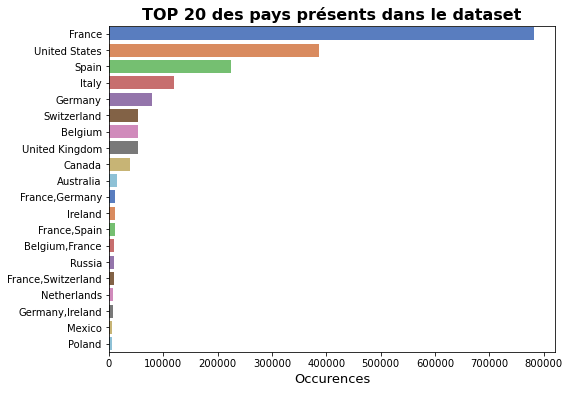

In [80]:
countries_en_count = openfoodfacts_en['countries_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
sns.barplot(y = countries_en_count.index, x = countries_en_count.values, palette = 'muted')
plt.title("TOP 20 des pays présents dans le dataset")
plt.ylabel("")
plt.xlabel("Occurences");

On remarque que la France est en tête du classement suivie des Etats Unis et de l'Espagne. Cette variable ne contient que 0.3% de valeurs manquantes et 4 403 valeurs distinctes: la variable countries_en ne contient pas forcément un seul pays mais peut également contenir une liste de pays. On peut se poser la question de savoir si la France peut être traduite dans une autre langue:

In [81]:
openfoodfacts_en[(~openfoodfacts_en['countries_en'].str.contains(
    'France', na = False)) & (openfoodfacts_en['countries_en'].str.contains(
    'Fr', na = False))]['countries_en'].unique().tolist()

['Austria,Frankreich,Spanien',
 'French Polynesia,United States',
 'French Polynesia',
 'Mexico,Thailand,United States,Francia',
 'Kuwait,Spain,Francia',
 'Spain,Francia',
 'French Guiana',
 'Mexico,Spain,United States,Francia',
 'Mexico,Spain,Estados-unidos,Francia',
 'Spain,Estados-unidos,Francia',
 'Germany,Frankreich',
 'Austria,Frankreich',
 'Canada,French Polynesia',
 'Italy,Spain,Francia,Marruecos,Reino-unido',
 'American Samoa,Australia,Austria,Azerbaijan,Democratic Republic of the Congo,French Southern and Antarctic Lands',
 'Andorra,Portugal,Spain,Francia',
 'Portugal,Deutschland,Frankreich,Niederlande,Spanien',
 'Belgica,Francia',
 'Frankreich',
 'Francja,Niemcy,Polska,Szwajcaria',
 'Spain,Eslovenia,Francia',
 'Germany,Italy,Francia,Germania,Svizzera',
 'Spain,Alemania,Francia',
 'Francia-espana',
 'Spain,Francia,Suecia,Suiza',
 'Germany,Frankreich,Irland',
 'Italy,Spain,Alemania,Belgica,Francia,Suiza',
 'Germany,Portugal,Frankreich',
 'Austria,Germany,Frankreich,Schweiz',
 

On remarque que les pays peuvent apparaitre dans plusieurs langues. Quelques exemples pour la France:
- Frankreich
- French
- Francia
- Francja
- Frankrijk
- Franța
- Franca

On apprend sur le site https://www.economie.gouv.fr/dgccrf/Publications/Vie-pratique/Fiches-pratiques/Etiquetage-des-denrees-alimentaires que les étiquettes doivent être traduites au moins en français pour les produits vendus en France. Gardons cela en tête pour la suite du nettoyage.

### Variables sur le packaging <a class="anchor" id="packaging"></a>

Ces variables ne seront a priori pas utilisées par la suite, supprimons les mais regardons d'abord quelques exemples.

In [82]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'packaging')

In [83]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging_tags,object,"barquette,plastique",2053679,46485,2.26,315895,15.38,1737784,84.62
1,packaging_text,object,1 pot en verre à recycler,2053679,4306,0.21,8240,0.40,2045439,99.60
2,first_packaging_code_geo,object,"47.833333,-0.333333",2053679,3768,0.18,73908,3.60,1979771,96.40


In [84]:
tab_modalities

,packaging_tags,packaging_text,first_packaging_code_geo
1104509,"carton,boite,cellulose,fr-boite-en-carton",1 étiquette papier à recycler. 1 boîte carton (cellulose) à recycler ou à composter (attestée par le label OK COMPOST et climatiquement neutre attestée par le label ClimatePartner).,"46,5.166667"
905425,etui-carton,Etui carton à recycler,"48.733333,2.283333"
772188,"sous-vide,sachet,plastique",films plastique à jeter,"49.016667,2.466667"
930954,"pot-carton,couvercle-carton,opercule-metal","1 Pot carton à recycler, 1 couvercle carton à recycler, 1 opercule métal à recycler","48.55,-2.216667"
824869,"sec,plastique",1 SACHET ET FERMOIR PLASTIQUE A JETER,"47.45,3.516667"


Ces variables étant assez peu alimentées et non pertinentes pour notre idée d'application, supprimons les.

In [85]:
# Suppression des variables contenant le mot packaging
openfoodfacts_en.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 116


### Variables sur la marque <a class="anchor" id="brand"></a>

In [86]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'brand')

In [87]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,brands_tags,object,endives,2053679,141427,6.89,1050528,51.15,1003151,48.85
1,brand_owner,object,LAGG'S,2053679,25576,1.25,290020,14.12,1763659,85.88


In [88]:
tab_modalities

,brands_tags,brand_owner
36067,"big-y,big-y-foods-inc","Big Y Foods, Inc."
419658,"superior-nut-candy,superior-nut-candy-distribut-g",Superior Nut/candy Distribut'G
13475,roundy-s,ROUNDY'S
488806,stark-raving-foods,Stark Raving Foods LLC
214069,entenmann-s,"Bimbo Bakeries USA, Inc."


La variable brands_tags comporte bien moins de valeurs manquantes que brand_owner même si elle a plus de valeurs distinctes. Nous décidons de conserver brands_tags.

In [89]:
# Suppression de la variable brand_owner
openfoodfacts_en.drop('brand_owner', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 115


### Variables sur le nom des produits <a class="anchor" id="name"></a>

In [90]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'name')

In [91]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,product_name,object,jeunes pousses,2053679,1276058,62.14,1970360,95.94,83319,4.06
1,abbreviated_product_name,object,Amora Moutarde Strong 6x2.5Kg 1x,2053679,7073,0.34,7197,0.35,2046482,99.65
2,generic_name,object,Blanquette de Volaille et son Riz,2053679,89427,4.35,123512,6.01,1930167,93.99


In [92]:
tab_modalities

,product_name,abbreviated_product_name,generic_name
890123,"Spécialité laitière sucrée, aromatisée",Sla perle de lait aromatise vanille 125gx4 offre speciale,"Spécialité laitière sucrée, aromatisée"
737384,BLEDINE 200g Multicéréales & Fruits Rouges Dès 6 mois,Bledine 200g multi frr,Préparation à base de céréales instantanées adaptée à bébé.
734800,Panzani - spf - sauce tomates & basilic,Pz tomate basilic 210 /12,"Sauce tomate cuisinée aux tomates fraîches et au basilic, aromatisée"
889731,Spécialité laitière sucrée aromatisée enrichie en calcium et vitamine D,Sla petit filous tubs aromatises fraise 40gx12,Spécialité laitière sucrée aromatisée enrichie en calcium et vitamine D
1043638,Ma'fruiT Mangues séchées,Ma'fruiT Mangues séchées 30g,Mangues séchées


Ces trois variables nous apportent la même information. abbreviated_product_name et generic_name ayant un fort pourcentage de valeurs manquantes, nous décidons de supprimer ces 2 variables.

In [93]:
# Suppression des variables abbreviated_product_name et generic_name
openfoodfacts_en.drop(['abbreviated_product_name', 'generic_name'], axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 113


### Variables sur les additifs <a class="anchor" id="additives"></a>

In [94]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'additives')

In [95]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,additives_n,float64,0.0,2053679,40,0.0,732673,35.68,1321006,64.32
1,additives_en,object,"E296 - Malic acid,E330 - Citric acid,E552 - Calcium silicate,E950 - Acesulfame k,E955 - Sucralose",2053679,100577,4.9,423384,20.62,1630295,79.38


In [96]:
tab_modalities

,additives_n,additives_en
792141,7.0,"E222 - Sodium bisulphite,E250 - Sodium nitrite,E301 - Sodium ascorbate,E322 - Lecithins,E322i - Lecithin,E392 - Extracts of rosemary,E450 - Diphosphates,E500 - Sodium carbonates"
1283307,1.0,E252 - Potassium nitrate
498948,1.0,"E322 - Lecithins,E322i - Lecithin"
487410,2.0,"E202 - Potassium sorbate,E330 - Citric acid"
1836060,1.0,"E322 - Lecithins,E322i - Lecithin"


Le pourcentage de valeurs manquantes étant "acceptable", nous décidons de conserver ces variables pour le moment.

### Variables sur les dates <a class="anchor" id="dates"></a>

In [97]:
# Colonnes dont le titre se termine par "_t" ou "_datetime"
print("Liste des variables dont le titre se termine par _t ou _datetime: ")
liste_col_date = openfoodfacts_en.iloc[:,(openfoodfacts_en.columns.str.endswith('_datetime')) |
                   (openfoodfacts_en.columns.str.endswith('_t'))].columns.tolist()
liste_col_date

Liste des variables dont le titre se termine par _t ou _datetime: 


['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']

In [98]:
# Passage au bon format
from datetime import datetime
import time

for column in liste_col_date:
    if column.endswith('_t'):
        openfoodfacts_en[column] = pd.to_datetime(openfoodfacts_en[column], unit='s')
    else:
        openfoodfacts_en[column] = pd.to_datetime(openfoodfacts_en[column], format="%Y-%m-%d %H:%M:%S.%f", utc=True)

In [99]:
openfoodfacts_en[liste_col_date].head()

,created_t,created_datetime,last_modified_t,last_modified_datetime
0,2021-06-16 14:53:28,2021-06-16 14:53:28+00:00,2021-06-16 14:53:29,2021-06-16 14:53:29+00:00
1,2021-09-01 08:11:51,2021-09-01 08:11:51+00:00,2021-09-01 08:14:24,2021-09-01 08:14:24+00:00
2,2018-06-15 10:38:00,2018-06-15 10:38:00+00:00,2019-06-25 11:55:18,2019-06-25 11:55:18+00:00
3,2018-10-13 21:06:14,2018-10-13 21:06:14+00:00,2018-10-13 21:06:57,2018-10-13 21:06:57+00:00
4,2019-11-19 15:02:16,2019-11-19 15:02:16+00:00,2021-06-22 19:39:25,2021-06-22 19:39:25+00:00


On remarque de la redondance d'information, on supprime les variables qui se terminent par _datetime.

In [100]:
# Suppression des variables redondantes
openfoodfacts_en.drop(['created_datetime', 'last_modified_datetime'], axis=1, inplace = True)

In [101]:
# On renomme les variables de date
openfoodfacts_en.rename(columns={'created_t': 'creation_date', 
                              'last_modified_t': 'last_modified_date'}, inplace = True)

In [102]:
# On créé des variables "Année"
#openfoodfacts_en['creation_year'] = pd.to_datetime(openfoodfacts_en['creation_date'], format='%d:%m:%Y').dt.year
#openfoodfacts_en['last_modified_year'] = pd.to_datetime(openfoodfacts_en['last_modified_date'], format='%d:%m:%Y').dt.year

In [103]:
# On décale les colonnes "Année" après les colonnes de date:
#colonne_a_decaler = openfoodfacts_en.pop('creation_year') 
#openfoodfacts_en.insert(openfoodfacts_en.columns.get_loc("creation_date")+1, 'creation_year', colonne_a_decaler) 

#colonne_a_decaler = openfoodfacts_en.pop('last_modified_year') 
#openfoodfacts_en.insert(openfoodfacts_en.columns.get_loc("last_modified_date")+1, 'last_modified_year', colonne_a_decaler) 

In [104]:
#openfoodfacts_en.dtypes[0:10]

### Variables sur les portions <a class="anchor" id="serving"></a>

Les variables qui commencent par serving_ correspondent au nombre de nutriments (en g, ou kj pour l'énergie) pour une part du produit. Elles doivent être de type numérique.

In [105]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'serving')

In [106]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,serving_size,object,serving,2053679,47101,2.29,509794,24.82,1543885,75.18
1,serving_quantity,float64,28.0,2053679,2456,0.12,505560,24.62,1548119,75.38


In [107]:
tab_modalities

,serving_size,serving_quantity
1553240,100g,100.0
217606,12 OZA (355 ml),355.0
91129,0.5 PIZZA (163 g),163.0
99811,1.6 ONZ (45 g),45.0
1166219,"0,5L",500.0


Ces 2 colonnes semblent être redondantes. Le % de NaN étant assez similaire et la variable serving_quantity déjà au format numérique, supprimons la variable serving_size.

In [108]:
# Suppression de la variable serving_size
openfoodfacts_en.drop('serving_size', axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 110


### Variables sur les labels <a class="anchor" id="labels"></a>

In [109]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'labels')

In [110]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,labels_en,object,fr:delois-france,2053679,60362,2.94,438458,21.35,1615221,78.65


In [111]:
tab_modalities

,labels_en
891443,"French meat,Green Dot,Made in France,No additives,fr:Origine France,fr:Triman"
1261061,Organic
809472,Green Dot
727381,"No artificial colors,No colorings,No flavors,No preservatives"
549411,No palm oil


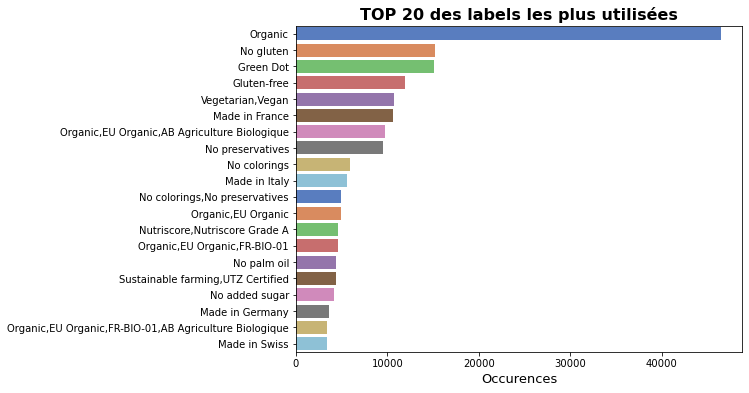

In [112]:
labels_en_count = openfoodfacts_en['labels_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
sns.barplot(y = labels_en_count.index, x = labels_en_count.values, palette = 'muted')
plt.title("TOP 20 des labels les plus utilisées")
plt.ylabel("")
plt.xlabel("Occurences");

Gardons cette variable qui permet notamment de savoir si le produit provient de l'agriculture biologique par exemple.

### Variables sur les scores <a class="anchor" id="scores"></a>

#### Nutriscore

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :

- en nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en nutriments à limiter (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

In [113]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'nutriscore')

In [114]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,nutriscore_score,float64,18.0,2053679,56,0.0,730959,35.59,1322720,64.41
1,nutriscore_grade,object,d,2053679,5,0.0,730959,35.59,1322720,64.41


In [115]:
tab_modalities

,nutriscore_score,nutriscore_grade
67237,15.0,d
1041127,21.0,e
1719411,2.0,b
1449444,6.0,c
563962,10.0,c


Il parait plus pertinent de conserver le nutriscore_grade qui figure sur les produits. Le nutriscore_score permet juste d'associer le produit à une lettre en fonction de son score.

In [116]:
# Suppression de la variable nutriscore_score
openfoodfacts_en.drop('nutriscore_score', axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 109


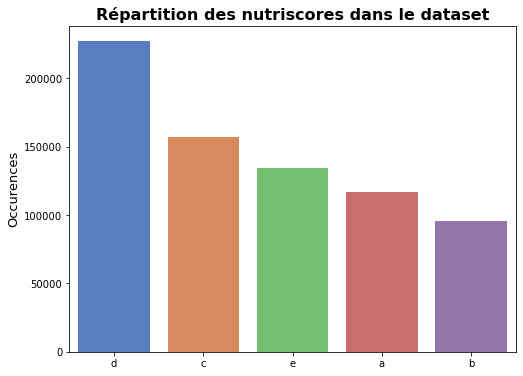

In [117]:
nutriscore_count = openfoodfacts_en['nutriscore_grade'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x = nutriscore_count.index, y = nutriscore_count.values, palette = 'muted')
plt.title("Répartition des nutriscores dans le dataset")
plt.ylabel("Occurences")
plt.xlabel("");

Les produits les plus mal notés semblent être ceux qui sont le plus représentés.

#### Groupe Nova

Les groupes Nova correspondent à une classification en 4 groupes selon le degré de transformation des aliments.
- Groupe 1 - Aliments non transformés ou transformés minimalement
- Groupe 2 - Ingrédients culinaires transformés
- Groupe 3 - Aliments transformés
- Groupe 4 - Produits alimentaires et boissons ultra-transformés

De nouvelles recherches de chercheurs de l'Inserm, de l'Inra et de l'Université Paris 13 (EREN) suggèrent une corrélation entre la consommation d'aliments ultra-transformés et un risque accru de développer un cancer.

In [118]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'nova_group')

In [119]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,nova_group,float64,4.0,2053679,4,0.0,640096,31.17,1413583,68.83


In [120]:
# Transformons cette variable en int
col = np.array(openfoodfacts_en['nova_group'], np.int8) # conversion en numpy array

openfoodfacts_en['nova_group'] = col # remplacement de nova group par le numpy array

In [121]:
# On remplace les 0 par NaN
openfoodfacts_en.loc[openfoodfacts_en['nova_group'] == 0, 'nova_group'] = np.nan

In [122]:
# On rajoute Group devant le numéro
openfoodfacts_en['nova_group'] = [f'Group {i}' for i in openfoodfacts_en['nova_group']]

In [123]:
# On enlève le .0 qui apparait après le nombre
openfoodfacts_en['nova_group'] = [str(i).replace('.0', '') for i in openfoodfacts_en['nova_group']]

In [124]:
# On transforme Group nan en np.nan
openfoodfacts_en.loc[openfoodfacts_en['nova_group'] == 'Group nan', 'nova_group'] = np.nan

In [125]:
# Fréquence de nova group dans le dataset
nova_percent = openfoodfacts_en[openfoodfacts_en['nova_group'] != 'nan'][
    'nova_group'].value_counts(normalize=True) * 100

In [126]:
data = nova_percent.values
labels = nova_percent.index

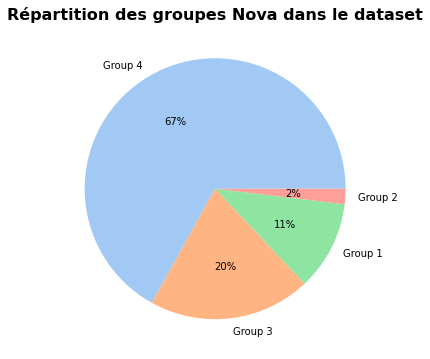

In [127]:
colors = sns.color_palette('pastel')[0:4]

plt.figure(figsize=(8, 6))
plt.title("Répartition des groupes Nova dans le dataset")
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%');

De la même manière que le nutriscore, les produits les plus transformés sont les plus représentés dans le dataset.

#### Ecoscore

L'Eco-Score est un score écologique (écoscore) de A à E qui permet de comparer facilement l'impact des produits alimentaires sur l'environnement. Pour chaque catégorie de produits, un score de référence est établi grâce aux données de la base environnementale Agribalyse conçue par l’ADEME et l’INRAE. Ces données correspondent à l’analyse de cycle de vie (ACV) des produits.

In [128]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'ecoscore')

In [129]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,ecoscore_score_fr,float64,34.0,2053679,9,0.0,10,0.0,2053669,100.0
1,ecoscore_grade_fr,object,d,2053679,5,0.0,10,0.0,2053669,100.0


On retrouve seulement 10 valeurs renseignées pour les variables ecoscore. Nous les supprimons.

In [130]:
# Suppression des variables
openfoodfacts_en.drop(['ecoscore_score_fr', 'ecoscore_grade_fr'], axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 107


### Variables sur les catégories de produits <a class="anchor" id="categ"></a>

#### Categories

In [131]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'categ')

In [132]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_en,object,"Groceries,Condiments,Sauces,Mustards",2053679,72800,3.54,945141,46.02,1108538,53.98
1,main_category,object,en:mustards,2053679,32887,1.60,945141,46.02,1108538,53.98
2,main_category_en,object,Mustards,2053679,32885,1.60,945141,46.02,1108538,53.98


In [133]:
tab_modalities

,categories_en,main_category,main_category_en
94786,"Snacks,Sweet snacks,Confectioneries",en:confectioneries,Confectioneries
886715,"Plant-based foods and beverages,Plant-based foods,Groceries,Condiments,Spices,Cinnamon",en:cinnamon,Cinnamon
841095,"Groceries,Sauces,Salad dressings,Vinaigrettes",en:vinaigrettes,Vinaigrettes
592838,"Dairies,Fermented foods,Fermented milk products,Cheeses,Italian cheeses,Grana Padano",en:grana-padano,Grana Padano
1881974,"Plant-based foods and beverages,Plant-based foods,Fats,Vegetable fats,Olive tree products,Vegetable oils,Olive oils,Virgin olive oils,Extra-virgin olive oils",en:extra-virgin-olive-oils,Extra-virgin olive oils


Ces 3 variables nous apportent la même information avec plus ou moins de détail. On note que les variables main_category sont égales au dernier élément de la liste categories_en. Le pourcentage de valeurs manquantes étant le même, notre critère de sélection sera porté sur le pourcentage de valeurs distinctes. Parmi les 2 variables avec le taux de valeurs distinctes le plus bas, nous décidons de conserver main_category_en.

In [134]:
# Suppression des variables categories_en et main_category
openfoodfacts_en.drop(['categories_en', 'main_category'], axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 105


Regardons plus en détail les différentes modalités de la variable categories_en.

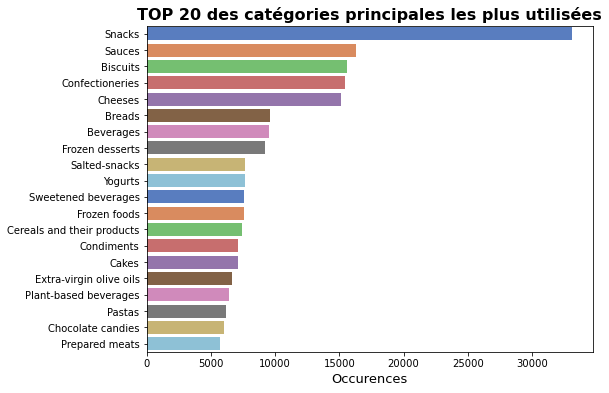

In [135]:
main_category_en_count = openfoodfacts_en['main_category_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
sns.barplot(y = main_category_en_count.index, x = main_category_en_count.values, palette = 'muted')
plt.title("TOP 20 des catégories principales les plus utilisées")
plt.ylabel("")
plt.xlabel("Occurences");

Cette variable pourrait être utilisée pour permettre de proposer un produit équivalent, mieux noté.

#### Groupes pnns

Le Programme national nutrition santé a été créé en 2001, et son site grand public a été lancé à la rentrée 2004, par l'Agence française de sécurité sanitaire des aliments et poursuivi par l'Agence nationale de santé publique. 

Ce programme a pour objectif général l’amélioration de l’état de santé de l’ensemble de la population en agissant sur l’un de ses déterminants majeurs : la nutrition. Ce programme agit à plusieurs niveaux: industrie, consommateurs, recherche afin d'atteindre ses objectifs (par exemple : diminution de la consommation de sel).

In [136]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts_en, 'pnns')

In [137]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,pnns_groups_1,object,unknown,2053679,12,0.0,2053552,99.99,127,0.01
1,pnns_groups_2,object,unknown,2053679,42,0.0,2053554,99.99,125,0.01


In [138]:
tab_modalities

,pnns_groups_1,pnns_groups_2
1885984,unknown,unknown
427606,Cereals and potatoes,Cereals
840938,Fat and sauces,Fats
1157967,unknown,unknown
192179,unknown,unknown


Les variables pnns_groups n'ont que 0.01 % de NaN, mais il semble y avoir la mention "unknown" qui correspond en réalité à une valeur non renseignée. Regardons les différentes modalités de ces variables.

In [139]:
# Vérification des mentions unknown
openfoodfacts_en[openfoodfacts_en[['pnns_groups_1', 'pnns_groups_2']]== "unknown"][
    ['pnns_groups_1', 'pnns_groups_2']]

,pnns_groups_1,pnns_groups_2
0,unknown,unknown
1,unknown,unknown
2,unknown,unknown
3,unknown,unknown
4,unknown,unknown
...,...,...
2053674,unknown,unknown
2053675,unknown,unknown
2053676,unknown,unknown
2053677,unknown,unknown


Il semblerait que quand l'un des groupes pnns soit unknown, l'autre le soit aussi. Regardons si l'on peut obtenir plus d'information en rajoutant la colonne main_category_en.

In [140]:
openfoodfacts_en[openfoodfacts_en[['pnns_groups_1', 'pnns_groups_2', 'main_category_en']].notnull().all(1)][
    ['pnns_groups_1', 'pnns_groups_2', 'main_category_en']]

,pnns_groups_1,pnns_groups_2,main_category_en
7,Fat and sauces,Dressings and sauces,Mustards
16,unknown,unknown,Almond paste
17,Composite foods,One-dish meals,Seasoned shredded carrots
26,Sugary snacks,Biscuits and cakes,Coconut pies
36,Fruits and vegetables,Fruits,Pear compotes
...,...,...,...
2053667,unknown,unknown,Sweet Fritters
2053670,Sugary snacks,Biscuits and cakes,de:tiefkühl-kuchen
2053671,Fish Meat Eggs,Meat,Ground beef steaks
2053672,Sugary snacks,Sweets,Marrons glacés


Nous allons remplacer la mention unknown des pnns_groups_1 et pnns_groups_2 par np.nan afin de connaitre le nombre réel de valeurs manquantes.

In [141]:
openfoodfacts_en.loc[openfoodfacts_en['pnns_groups_1'] == 'unknown', 'pnns_groups_1'] = np.nan
openfoodfacts_en.loc[openfoodfacts_en['pnns_groups_2'] == 'unknown', 'pnns_groups_2'] = np.nan

In [142]:
describe_variables_light(openfoodfacts_en[['pnns_groups_1', 'pnns_groups_2']])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,pnns_groups_1,object,Fat and sauces,2053679,11,0.0,770473,37.52,1283206,62.48
1,pnns_groups_2,object,Dressings and sauces,2053679,41,0.0,770475,37.52,1283204,62.48


Les variables pnns contiennent en réalité 62.48% de NaN et sont donc moins bien remplies que la variable main_category_en. Regardons maintenant les categories lorsque les pnns ne sont pas renseignés.

In [143]:
openfoodfacts_en[(openfoodfacts_en[['pnns_groups_1', 'pnns_groups_2']].isna().all(1)) & 
                 ((openfoodfacts_en['main_category_en'].notnull()))][
    ['pnns_groups_1', 'pnns_groups_2', 'main_category_en', 'countries_en']]

,pnns_groups_1,pnns_groups_2,main_category_en,countries_en
16,NaN,NaN,Almond paste,France
169,NaN,NaN,Dietary supplements,France
176,NaN,NaN,fr:filet-de-boeuf,France
327,NaN,NaN,Food decorations,France
353,NaN,NaN,fr:gateaux-aux-noix,France
...,...,...,...,...
2053608,NaN,NaN,hu:extrudált-kukorica,Hungary
2053616,NaN,NaN,Meat analogues,Germany
2053658,NaN,NaN,Chocolate mousses,France
2053667,NaN,NaN,Sweet Fritters,France


Nous allons conserver ces variables pour le moment et voir si nous pouvons compléter les groupes pnns dans la partie sur la gestion des valeurs manquantes.

Cette meilleure connaissance des variables présentes dans le dataset nous a permis d'identifier les variables pertinentes pour notre application. Nous allons donc pouvoir, dans la partie suivante commencer à filtrer notre jeu de données pour ne garder que les variables essentielles.

## Sélection de variables pertinentes en lien avec le choix d'application <a class="anchor" id="selec_var"></a>

<div class="alert alert-block alert-warning">
    <p> Suppression de variables pour libérer de la RAM </p>
</div>

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Je souhaite y contribuer en proposant **une nouvelle signalétique permettant aux femmes enceintes de s'assurer que le produit ne contient pas d'aliment proscrit pendant la grossesse et de proposer une alternative avec le meilleur nutriscore si le produit sélectionné ne convient pas**.

Je me suis basée sur le guide nutrition de la grossesse dont les données proviennent de l'Agence française de sécurité sanitaire des aliments (AFSSA) disponibles en téléchargement sur le site de Santé Publique France à cette adresse: https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/documents/brochure/le-guide-nutrition-de-la-grossesse

On y retrouve les vitamines et oligoéléments essentiels pendant la grossesse tels que: 
- les **folates** (vitamine B9) pour le développement du système nerveux de l'embryon 
- le **calcium** (construction du squelette de l'enfant)
- la **viatmine D** qui permet à l'organisme à mieux absorber le calcium des aliments
- le **fer**
- l'**iode** (fonctionnement de la glande thyroïde + développement cerveau de l'enfant)


Certains aliments sont à proscrire pendant la grossesse ou à manger en petite quantité. Parmis eux: 
- l'**arachide** en cas d'allergie
- le **soja**
- **certains poissons**: anguille, barbeau, brème, carpe, silure, lotte, bar, bonite, empereur, grenadier, flétan, brochet, dorade, raie, sabre, thon, espadon, marlin, siki, requin, lamproie
- les boissons contenant de la **caféine**
- le foie et les **produits à base de foie**
- les **fromages à pâte molle à croûte fleurie** (type camembert, brie) et à **croûte lavée** (type munster, pont- l’évêque), surtout s’ils sont au lait cru ; les **fromages râpés industriels**
- certains produits de charcuterie, notamment **rillettes, pâtés, foie gras, produits en gelée**
- la **viande crue** ou peu cuite, le **poisson cru** (sushi, sashimi, tarama), les **poissons fumés** (saumon, truite),et les **crustacés décortiqués vendus cuits**
- les produits enrichis en **phytostérols**
- l'**alcool**

Nous allons donc filtrer le dataset sur les variables qui nous apportent de l'information sur les éléments ci-dessus. Notre application aura pour cible les femmes enceintes qui achètent en France. Il est en effet obligatoire de traduire les étiquettes dans la langue où le produit est vendu ce qui facilitera l'analyse. Cette application pourrait être adaptée à différents pays ultérieurement.

### Informations sur les produits  <a class="anchor" id="vitamines"></a>

Nous allons définir ici la liste des variables catégorielles dont nous aurons besoin pour notre application:

- **code**: code barres qui permettra de retrouver le produit lorsqu'on le prend en photo
- **last_modified_date**: date de dernière modification qui peut servir pour le traitement des doublons
- **product_name**: nom du produit
- **brands_tags**: marque du produit
- **countries_en**: pays où est vendu le produit (ce champs n'est pas harmonisé, nous verrons s'il sera utile pour la suite)
- **ingredients_text**: liste des ingrédients. On pourra filtrer sur ce champ pour récupérer la liste des produits à proscrire
- **allergens**: pour éviter les allergies alimentaire de la maman et de l'enfant comme l'arachide
- **labels_en**: cette variable permet de filtrer sur des labels biologiques par exemple
- **nutriscore_grade**: permet de connaitre la qualité d'un produit (prend en compte les aliments à favoriser et les nutriments à limiter)
- **nova_group**: informations sur le degré de transformation des aliments
- **pnns_groups**: classement des produits par l'Agence Française de la Santé Publique
- **main_category_en**: catégorisation des aliments par openfoodfacts

Cette liste pourra être modifiée par la suite pour coller au mieux à nos besoins.

In [144]:
# Copie du dataset
openfoodfacts_light = openfoodfacts_en.copy()

In [145]:
liste_var_categ = ['code', 'last_modified_date', 'product_name', 'brands_tags', 'countries_en', 
                   'ingredients_text', 'allergens', 'labels_en', 'nutriscore_grade', 
                  'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']

In [146]:
openfoodfacts_light.iloc[:, openfoodfacts_light.columns.isin(liste_var_categ)].head()

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en
0,00000000000000225,2021-06-16 14:53:29,jeunes pousses,endives,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,2021-09-01 08:14:24,L.casei,NaN,NaN,Spain,"Leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene Lactobacidus casei), vitaminas (B6 y D).",NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,2019-06-25 11:55:18,Vitória crackers,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,2018-10-13 21:06:57,Cacao,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,2021-06-22 19:39:25,Filetes de pollo empanado,NaN,NaN,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Vitamines et oligoéléments essentiels  <a class="anchor" id="vitamines"></a>

Les nutriments sont des variables distinctes dans le dataset. Nous allons filtrer ce dernier sur les nutriments essentiels traduits en anglais.

In [147]:
# Liste des nutriments essentiels
liste_nutriments_essentiels = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains(
    'folates|vitamin-b9|calcium|vitamin-d|iron|iodine')].columns.tolist()

### Alcool et caféine  <a class="anchor" id="alcool"></a>

In [148]:
# Liste des nutriments à éviter
liste_alcool_cafeine = openfoodfacts_en.iloc[:,openfoodfacts_en.columns.str.contains(
    'alcohol|caffeine')].columns.tolist()

### Aliments à proscrire  <a class="anchor" id="proscrire"></a>

Les aliments à proscrire sont des modalités de la variable ingredients_text. On pourra repérer les aliments qu'il faut éviter de consommer en cas d'allergie alimentaire dans la variable allergens. Pour certaines catégories d'aliments comme certains poissons ou types de fromages, nous verrons par la suite comment les identifier.

In [149]:
# Liste des aliments à proscrire
openfoodfacts_en[openfoodfacts_en['ingredients_text'].str.contains(
    'soja|caféine|foie|phytostérols', na = False)][['product_name', 'ingredients_text']].head(5)

,product_name,ingredients_text
468,Preparation mug cake chocolat-caramel au beurre salé,"farine de blé (gluten), sucre de canne, pépites de chocolat n Ir à 50 % de cacao minimum 19,9 % (pâte de cacao, sucre de canne, beurre de cacao, émulsifiant : lécithine de soja), cacao biologique en poudre 7,9 0%, caramel tendre d'Isigny au beurre salé 5,9 % (sirop de glucose, sucre, lait entier en salé Isigny AOP (lait), eau, sel de Guérande, arôme naturel vanille, poudre à lever : bicarbonate de soude, émulsifiant : sucroesters d'acides gras), bicarbonate de soude, diphosphate dissodique. Peut contenir des traces de fruits à coques moutjrde, sésame, gluten, lait, œuf, soja et sulfites."
476,Colorant alimentaire bleu velours en spray,"VELOURS EN S RAY dessert, passé préalableme Bien agiter avant emploi. l'on souhaite traiter à ure distance cz de cacao, colorants : E171, El)) des traces de lait, soja, fruits à : Ne pas ingérer direce&lt; sin aler les vapeurs directeme,: Viter l'emploi excessif Utiliser sev zk. Ne pas perforer ni brûler, lamer avers une flamme ou Garder la bombe hors de la tfdernent s'il est complétement *f est possible.dans des Ne pas' avaler tel quel. un endroit sec et frais, à te du soleil ELAUW IN VELOURs dessert dat net ult de d eq• - k.dden voor cjebrujk."
497,Preparation biscuits cacao/noisette,"farine de riz, sucre, amidon de maïs, cacao (4.8%), farine de noisette arômes, émulsifiants esters polyglycériques d'acides gras, monooléate de polyoxyéthylène de sorbitane ; épaississants : gomme guar, carboxyméthylcellu- lose ; poudre à lever : carbonate de sodium; correcteur d'acidité . glucono-delta-lactine, sel. Peut contenir des traces de lait œufs, soja et autres fruits à coque."
499,Chocolat lait noisette,"FR - CHOCOLAT LAIT (40% min. caéao) AVEC NOISETTES : beurre de cacao, lait enfer en poudre, sucre de cannet sucre, pâte de cacao, noisettes(4%), émulsifiant : lécithine de (E322), arôme naturel de noisette, arôme naturel de vanille, arôme naturel de nougat sel. Peut contenir des fraces de glutenzsoja, Conseils de conservation : A conserver entre 15 C et 200C, à l'abri de la chaleur et de l'humidité. Plongez et mélangez la cuillère&ns une tasse de lait chaud."
581,mini doony's chocolat x8,"farine: BLE, SOJA huiles et graisses vegetales (palme, coprah, colza, karite, tournesol); eau; sucre dextrose; poudre de cacao degraissee (1, 5%); levure; lactoserum en poudre (LAIT) , sel poudre a lever : E450i, E500i; emulsifiant: E471, E481, E472e ; poudre de LAIT ecreme;aromes. Produit dans une usine qui utilise soja, lait, oeufs, fruits a coque. Allergènes: BLE LAIT SOJA Produit congelé, ne pas recongeler"


### Filtre sur les variables retenues  <a class="anchor" id="filtre_var"></a>

In [150]:
var_a_conserver = liste_var_categ + liste_nutriments_essentiels + liste_alcool_cafeine

In [151]:
openfoodfacts_light = openfoodfacts_light.iloc[:,openfoodfacts_light.columns.isin(var_a_conserver)]

In [152]:
print(f"Nombre de lignes: {openfoodfacts_light.shape[0]}\nNombre de variables: {openfoodfacts_light.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 21


## Doublons <a class="anchor" id="doublons"></a>

Il est important de vérifier que le dataset ne contienne pas de doublons. La variable "code" semble représenter la clé primaire de notre table. Vérifions dans un premier temps si cette variable contient plusieurs fois le même code. Ensuite nous vérifierons si un même produit existe plusieurs fois dans la base et adopterons une stratégie pour son traitement.  

### Variable Code <a class="anchor" id="doublons_code"></a>

In [153]:
# Nombre de doublons sur la colonne code
print(f"Codes en doublons: {openfoodfacts_light.duplicated('code').sum()}")

Codes en doublons: 15


In [154]:
# Supprimons les lignes dupliquées qui ont le plus grand nombre de NaN par lignes
openfoodfacts_light['null_count'] = openfoodfacts_light.isnull().sum(1)

openfoodfacts_not_duplicated = openfoodfacts_light.sort_values('null_count')\
       .drop_duplicates(subset = "code")\
       .sort_index()

In [155]:
print(f"Nombre de lignes: {openfoodfacts_not_duplicated.shape[0]}\nNombre de variables: {openfoodfacts_not_duplicated.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 22


In [156]:
# Suppression de la variable null_count
openfoodfacts_not_duplicated.drop('null_count', axis='columns', inplace = True)

In [157]:
openfoodfacts_light.shape[0] - openfoodfacts_not_duplicated.shape[0]

15

### Variable Product Name <a class="anchor" id="doublons_product"></a>

Dans un premier temps, afin d'éviter d'avoir des produits différents à cause de la casse, modifions toutes les modalités des colonnes de type object en minuscules.

In [158]:
liste_col_object = openfoodfacts_not_duplicated.select_dtypes(include=['object']).columns.tolist()

for col in liste_col_object:
    openfoodfacts_not_duplicated[col] = openfoodfacts_not_duplicated[col].str.lower()
    
openfoodfacts_not_duplicated.head(2)

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,alcohol_100g,vitamin-d_100g,vitamin-b9_100g,folates_100g,calcium_100g,iron_100g,iodine_100g,caffeine_100g
0,00000000000000225,2021-06-16 14:53:29,jeunes pousses,endives,NaN,france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,2021-09-01 08:14:24,l.casei,NaN,NaN,spain,"leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene lactobacidus casei), vitaminas (b6 y d).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# Nombre de doublons sur la colonne product_name
print(f"Produits en doublons: {openfoodfacts_not_duplicated.duplicated('product_name').sum()}")

Produits en doublons: 884162


Plus de 84 000 produits ont le même nom dans le dataset. Regardons quelques lignes afin de mieux comprendre.

In [160]:
# Liste des product_name dupliqués
liste_duplicated_products = openfoodfacts_not_duplicated[openfoodfacts_not_duplicated[
    'product_name'].duplicated()]['product_name'].tolist()

In [161]:
# Affichage des lignes dupliquées du dataset
openfoodfacts_not_duplicated[openfoodfacts_not_duplicated['product_name'].isin(
    liste_duplicated_products)].sort_values(by = 'product_name', ascending=True)

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,alcohol_100g,vitamin-d_100g,vitamin-b9_100g,folates_100g,calcium_100g,iron_100g,iodine_100g,caffeine_100g
1498906,6194001801033,2020-02-26 21:07:37,#energy fruits,NaN,no preservatives,france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498917,6194001801354,2021-10-30 10:37:10,#energy fruits,stil,no preservatives,tunisia,NaN,NaN,e,NaN,beverages,sweetened beverages,sweetened beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376873,5060367180048,2021-07-27 15:29:32,& nut smooth almond butter,NaN,NaN,france,"almonds (9.5%), sea salt (0.5%). allergy advice: for allergens, see ingredients in bold. not suitable for peanut and other nut allergy sufferers. storage: store in a cool, dry place. once open eat within 3 months (easy!)",NaN,d,NaN,NaN,NaN,almond butters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376880,5060367180390,2021-07-27 15:29:33,& nut smooth almond butter,NaN,NaN,france,NaN,NaN,d,NaN,NaN,NaN,almond butters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014276,9002859047589,2021-10-23 10:04:55,&quot,gunz,NaN,france,"dextrose, sirop de glucose, acidifiant : e330, emulsifiant: e470b, arôme, colorants: e100, e120, e133, e163, agent d'enrobage: e901, e903, e904,",NaN,NaN,group 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048404,9992233028456,2020-04-06 08:45:41,NaN,billa,NaN,"germany,ireland",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048406,999370,2021-07-15 14:40:33,NaN,NaN,NaN,france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048415,9996930882,2021-02-21 15:57:38,NaN,NaN,NaN,oman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048427,9998776132050,2020-11-08 10:03:24,NaN,NaN,NaN,germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


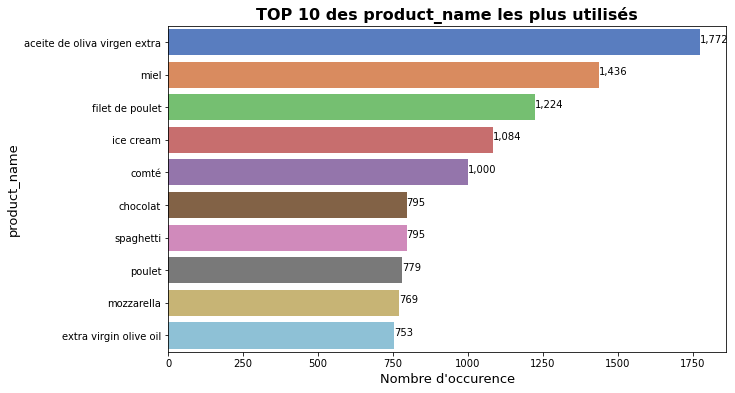

In [162]:
# Visualisation sous forme de countplot
plt.figure(figsize=(10,6))
ax = sns.countplot(y = 'product_name', data = openfoodfacts_not_duplicated,
                   order = openfoodfacts_not_duplicated['product_name'].value_counts().index[0:10],
                   palette = 'muted')
plt.title('TOP 10 des product_name les plus utilisés')
plt.xlabel("Nombre d'occurence")
etiquette_h(ax);

Regardons plus en détail le product_name 'aceite de oliva virgen extra' et définissons une stratégie pour assainir la base.

In [163]:
test_duplicated_huile_olive = openfoodfacts_not_duplicated[openfoodfacts_not_duplicated['product_name'] \
                                                           == 'aceite de oliva virgen extra']
test_duplicated_huile_olive.head(30)

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,alcohol_100g,vitamin-d_100g,vitamin-b9_100g,folates_100g,calcium_100g,iron_100g,iodine_100g,caffeine_100g
186463,0066958057053,2020-12-13 18:29:15,aceite de oliva virgen extra,castela-notti,NaN,spain,NaN,NaN,NaN,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287307,0096619215683,2021-05-01 14:26:31,aceite de oliva virgen extra,kirkland,NaN,spain,NaN,NaN,c,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334880,0224444444446,2021-09-12 13:50:34,aceite de oliva virgen extra,tudis,NaN,spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355315,03355533,2020-11-07 09:47:46,aceite de oliva virgen extra,NaN,NaN,spain,NaN,NaN,NaN,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355327,03357036,2020-03-19 20:36:50,aceite de oliva virgen extra,torres,NaN,spain,NaN,NaN,c,NaN,fat and sauces,fats,virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356756,03858815,2021-05-01 14:26:31,aceite de oliva virgen extra,NaN,NaN,spain,NaN,NaN,c,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359298,0448007687006,2021-05-01 14:26:32,aceite de oliva virgen extra,NaN,NaN,spain,NaN,NaN,c,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360468,04717,2021-05-01 14:26:36,aceite de oliva virgen extra,hacendado,NaN,spain,NaN,NaN,NaN,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369198,0614143376375,2021-04-29 18:25:35,aceite de oliva virgen extra,NaN,NaN,france,NaN,NaN,c,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379067,0634438969976,2021-05-01 14:26:37,aceite de oliva virgen extra,donatura,NaN,spain,NaN,NaN,c,NaN,fat and sauces,fats,extra-virgin olive oils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On pourrait imaginer ne conserver qu'un produit par marque. Regardons tout d'abord le nombre d'huiles d'olive par marque.

In [164]:
test_duplicated_huile_olive.groupby('brands_tags')['product_name'].count().sort_values(ascending = False).head()

brands_tags
puerta-de-las-villas    13
hacendado               11
abril                    8
dcoop                    7
coosur                   7
Name: product_name, dtype: int64

Il existe bien plusieurs produits ayant le même nom pour une même marque. Parmis ces doublons, nous pourrions imaginer remplir les valeurs manquantes par le mode puis conserver le produit dont la date de mise à jour est la plus récente. Cependant, les codes barres étant différents, nous ne pouvons pas considérer que ce sont des doublons. Nous traiterons les valeurs manquantes dans la partie associée.

## Gestion des valeurs aberrantes <a class="anchor" id="outliers"></a>

Les variables qui se terminent par 100g ne peuvent pas contenir de valeurs supérieures à 100 ou inférieures à 0. Vérifions si le dataset en contient. Nous remplacerons ces valeurs aberrantes par np.nan en attendant de traiter les valeurs manquantes par la suite.

In [185]:
# Valeurs aberrantes
openfoodfacts_not_duplicated[(openfoodfacts_not_duplicated["alcohol_100g"] > 100)
                              | (openfoodfacts_not_duplicated["vitamin-d_100g"] > 100)
                              | (openfoodfacts_not_duplicated["vitamin-b9_100g"] > 100)
                              | (openfoodfacts_not_duplicated["folates_100g"] > 100)
                              | (openfoodfacts_not_duplicated["calcium_100g"] > 100)
                              | (openfoodfacts_not_duplicated["iron_100g"] > 100)
                              | (openfoodfacts_not_duplicated["iodine_100g"] > 100)
                              | (openfoodfacts_not_duplicated["caffeine_100g"] > 100)]

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,alcohol_100g,vitamin-d_100g,vitamin-b9_100g,folates_100g,calcium_100g,iron_100g,iodine_100g,caffeine_100g
9670,0011110833037,2020-10-17 09:07:42,cereal toasted oats,simple-true-organic,NaN,united states,"organic whole grain oats (includes the oat bran), organic rice flour, organic sugar, salt, calcium carbonate, mixed tocopherols (vitamin e) added to preserve freshness, vitamins and minerals: ferric orthophosphate, sodium ascorbate, niacinamide, vitamin a acetate, zinc oxide, folic acid, cholecalciferol, thiamine mononitrate, pyridoxine hydrochloride.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.325000e-06,NaN,166.666672,0.200000,0.027,NaN,NaN
29032,0016000163447,2021-08-05 20:27:25,cheerios oat crunch,"general-mills,cheerios",NaN,united states,"whole grain oats, sugar, whole grain corn, modified corn starch, canola oil, corn starch, honey, whole grain rice, corn bran, whole grain sorghum, whole grain millet, salt, tripotassium phosphate, baking soda, color (caramel color and annatto extract), natural flavor. vitamin e (mixed tocopherols) added to preserve freshness. vitamins and minerals: calcium carbonate, iron and zinc (mineral nutrients), a b vitamin (niacinamide), vitamin c (sodium ascorbate), a b vitamin (calcium pantothenate), vitamin b6 (pyridoxine hydrochloride), vitamin b2 (riboflavin), vitamin b1 (thiamin mononitrate), a b vitamin (folic acid), vitamin b12, vitamin a (palmitate), vitamin d3.",NaN,d,group 4,cereals and potatoes,breakfast cereals,breakfast cereals,NaN,NaN,3.7000,NaN,241.000000,NaN,20.000,NaN
74112,0034000432240,2021-11-16 09:38:29,miniature cups,reese-s,"kosher,orthodox union kosher",france,"ry reese's peanu temptations visit www,reeses,com fo amount/serving dv* amount/serving nutrition % dv the val 6% you total fat 7g 10% total carb, 15g facts evings per container ing size ces (26g) sat, fat 3g trans fat o0g cholest, &lt;5mg sodium 80mg fiber &lt;1g 15% 3% ser total sugars 14g 1% con dail 26% 2,00 a da for g incl, 13g added sugars 3% protein 3g nutri 2% advic 2% ries rving 130 0% • calcium 30mg 4% • potas, 90mg vit, d 0,1mcg iron 0,7mg ts milk chocolate sugar: cocoa butter, chu and citric acid, to maintain freshness, od at skim milk, milk fat, lactose: lecith t by the hershey company shey pa 17033-0815, u,s,a, or comments? ershey,com or 800-468-1714 visit us at www,reeses,com the orange color is a registerert",en:milk,NaN,group 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.000000,2.690,NaN,NaN
96183,0041000002878,2021-11-09 01:49:08,black tea bag,lipton,NaN,united states,NaN,NaN,NaN,NaN,NaN,NaN,black teas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0
176313,0061200225914,2021-11-29 06:21:02,dairy milk,cadbury,"fair trade,fairtrade international,pure cocoa butter,chocolat-canada",canada,"chocolat au lait (sucre*, substances laitières, beurre de cacao*, chocolat non sucré*, lécithine de soja, arômes naturel et artificiels). peut contenir des arachides et/ou des noix. *certifié équitable.",NaN,e,group 4,sugary snacks,chocolate products,milk chocolates,NaN,NaN,NaN,NaN,238.000000,1.790,NaN,NaN
190049,0069143106888,2021-12-03 22:35:29,haloumi (plain),dore-mi,NaN,canada,"pasteurized milk, modified milk ingredients, pasteurized cream, salt, calcium chloride. microbial enzyme, bacterial culture, spices.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,667.000000,0.000,NaN,NaN
259059,0078742262994,2021-08-06 15:18:20,sharp cheddar cheese,great-value,"low or no fat,low fat,reduced fat",united states,"reduced fat sharp cheddar cheese (pasteurized part-skim milk, cheese culture, salt, enzymes, annatto color, vitamin a palmitate)",NaN,NaN,group 4,milk and dairy products,cheese,mature cheddar,NaN,NaN,0.3570,NaN,761.000000,NaN,NaN,NaN
296427,01609875,2021-08-28 14:27:24,honey nut cheerios treats,general-mills,NaN,united states,"cereal (whole grain oats, sugar, oat bran, corn starch, honey, 

In [ ]:
def outliers_100g(dataframe):
    ''' Fonction qui renvoie le dataframe avec les observations pour lesquelles les valeurs des colonnes
    numériques sont supérieures à 100 ou inférieures à 0 corrigées en np.nan'''
    
    for c in dataframe.columns:
        if dataframe[c].dtypes == 'float32': 
            outliers = dataframe[(dataframe[c] > 100) | (dataframe[c] < 0)].index
            dataframe.loc[outliers, c] = np.nan
    return dataframe

In [ ]:
openfoodfacts_outliers = outliers_100g(openfoodfacts_not_duplicated)

### Alcool

In [192]:
def outliers_100g(dataframe, colonne):
    ''' Fonction qui renvoie les observations pour lesquelles les valeurs de la colonne sélectionnés 
    en entrée sont supérieures à 100 ou inférieures à 0.'''
    outliers = dataframe[(dataframe[colonne] > 100) |
                             (dataframe[colonne] < 0)][['product_name', 'main_category_en', colonne]]
    return outliers

In [193]:
outliers_100g(openfoodfacts_not_duplicated, 'alcohol_100g')

,product_name,main_category_en,alcohol_100g
392006,NaN,NaN,5.000000e+23
789875,"buzet rouge les vignes de peyrau, bee friendly",alcoholic beverages,1.350000e+02
1216227,steam brew,alcoholic beverages,7.790000e+02
1216294,mesra cepat dan betul tegas adil dan berhemah 999s 32728s zd1s zl1s zu1s welfares malaysias amens amins,NaN,9.993273e+10
1538834,mesra cepat dan betul tegas adil dan berhemah 999s 32728s zd1s zl1s zu1s welfares malaysias amens amins,NaN,9.993273e+10


In [182]:
outliers_100g(openfoodfacts_not_duplicated, 'calcium_100g')

,product_name,main_category_en,calcium_100g
29032,cheerios oat crunch,breakfast cereals,241.000000
74112,miniature cups,NaN,115.000000
176313,dairy milk,milk chocolates,238.000000
190049,haloumi (plain),NaN,667.000000
259059,sharp cheddar cheese,mature cheddar,761.000000
296427,honey nut cheerios treats,cereals and their products,14000.000000
299274,macaroni & cheese,macaroni and cheese,119.000000
317787,"5 year, gouda cheese",NaN,125.000000
340226,tofou mariné à la japonaise,NaN,180.000000
358615,whole almonds,shelled almonds,250.000000


In [255]:
openfoodfacts_not_duplicated[(openfoodfacts_not_duplicated["alcohol_100g"] > 100)
                              | (openfoodfacts_not_duplicated["vitamin-d_100g"] > 100)
                              | (openfoodfacts_not_duplicated["vitamin-b9_100g"] > 100)
                              | (openfoodfacts_not_duplicated["folates_100g"] > 100)
                              | (openfoodfacts_not_duplicated["calcium_100g"] > 100)
                              | (openfoodfacts_not_duplicated["iron_100g"] > 100)
                              | (openfoodfacts_not_duplicated["iodine_100g"] > 100)
                              | (openfoodfacts_not_duplicated["caffeine_100g"] > 100)]

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,alcohol_100g,vitamin-d_100g,vitamin-b9_100g,folates_100g,calcium_100g,iron_100g,iodine_100g,caffeine_100g
9670,0011110833037,2020-10-17 09:07:42,cereal toasted oats,simple-true-organic,NaN,united states,"organic whole grain oats (includes the oat bran), organic rice flour, organic sugar, salt, calcium carbonate, mixed tocopherols (vitamin e) added to preserve freshness, vitamins and minerals: ferric orthophosphate, sodium ascorbate, niacinamide, vitamin a acetate, zinc oxide, folic acid, cholecalciferol, thiamine mononitrate, pyridoxine hydrochloride.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.325000e-06,NaN,166.666672,0.200000,0.027,NaN,NaN
29032,0016000163447,2021-08-05 20:27:25,cheerios oat crunch,"general-mills,cheerios",NaN,united states,"whole grain oats, sugar, whole grain corn, modified corn starch, canola oil, corn starch, honey, whole grain rice, corn bran, whole grain sorghum, whole grain millet, salt, tripotassium phosphate, baking soda, color (caramel color and annatto extract), natural flavor. vitamin e (mixed tocopherols) added to preserve freshness. vitamins and minerals: calcium carbonate, iron and zinc (mineral nutrients), a b vitamin (niacinamide), vitamin c (sodium ascorbate), a b vitamin (calcium pantothenate), vitamin b6 (pyridoxine hydrochloride), vitamin b2 (riboflavin), vitamin b1 (thiamin mononitrate), a b vitamin (folic acid), vitamin b12, vitamin a (palmitate), vitamin d3.",NaN,d,group 4,cereals and potatoes,breakfast cereals,breakfast cereals,NaN,NaN,3.7000,NaN,241.000000,NaN,20.000,NaN
74112,0034000432240,2021-11-16 09:38:29,miniature cups,reese-s,"kosher,orthodox union kosher",france,"ry reese's peanu temptations visit www,reeses,com fo amount/serving dv* amount/serving nutrition % dv the val 6% you total fat 7g 10% total carb, 15g facts evings per container ing size ces (26g) sat, fat 3g trans fat o0g cholest, &lt;5mg sodium 80mg fiber &lt;1g 15% 3% ser total sugars 14g 1% con dail 26% 2,00 a da for g incl, 13g added sugars 3% protein 3g nutri 2% advic 2% ries rving 130 0% • calcium 30mg 4% • potas, 90mg vit, d 0,1mcg iron 0,7mg ts milk chocolate sugar: cocoa butter, chu and citric acid, to maintain freshness, od at skim milk, milk fat, lactose: lecith t by the hershey company shey pa 17033-0815, u,s,a, or comments? ershey,com or 800-468-1714 visit us at www,reeses,com the orange color is a registerert",en:milk,NaN,group 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.000000,2.690,NaN,NaN
96183,0041000002878,2021-11-09 01:49:08,black tea bag,lipton,NaN,united states,NaN,NaN,NaN,NaN,NaN,NaN,black teas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0
176313,0061200225914,2021-11-29 06:21:02,dairy milk,cadbury,"fair trade,fairtrade international,pure cocoa butter,chocolat-canada",canada,"chocolat au lait (sucre*, substances laitières, beurre de cacao*, chocolat non sucré*, lécithine de soja, arômes naturel et artificiels). peut contenir des arachides et/ou des noix. *certifié équitable.",NaN,e,group 4,sugary snacks,chocolate products,milk chocolates,NaN,NaN,NaN,NaN,238.000000,1.790,NaN,NaN
190049,0069143106888,2021-12-03 22:35:29,haloumi (plain),dore-mi,NaN,canada,"pasteurized milk, modified milk ingredients, pasteurized cream, salt, calcium chloride. microbial enzyme, bacterial culture, spices.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,667.000000,0.000,NaN,NaN
259059,0078742262994,2021-08-06 15:18:20,sharp cheddar cheese,great-value,"low or no fat,low fat,reduced fat",united states,"reduced fat sharp cheddar cheese (pasteurized part-skim milk, cheese culture, salt, enzymes, annatto color, vitamin a palmitate)",NaN,NaN,group 4,milk and dairy products,cheese,mature cheddar,NaN,NaN,0.3570,NaN,761.000000,NaN,NaN,NaN
296427,01609875,2021-08-28 14:27:24,honey nut cheerios treats,general-mills,NaN,united states,"cereal (whole grain oats, sugar, oat bran, corn starch, honey, 

,code,last_modified_date,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,alcohol_100g,vitamin-d_100g,vitamin-b9_100g,folates_100g,calcium_100g,iron_100g,iodine_100g,caffeine_100g
392006,0678149032031,2021-04-03 11:39:31,NaN,NaN,NaN,spain,"ogro asno humanos dragon y más,mucho más",NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789875,3231230220921,2021-11-15 11:41:24,"buzet rouge les vignes de peyrau, bee friendly","buzet-rouge-les-vignes-de-peyrau,bee-friendly",NaN,france,NaN,NaN,NaN,NaN,alcoholic beverages,alcoholic beverages,alcoholic beverages,1.350000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1216227,4054500121037,2020-12-08 17:43:36,steam brew,steam-brew,NaN,switzerland,NaN,NaN,NaN,NaN,alcoholic beverages,alcoholic beverages,alcoholic beverages,7.790000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1216294,40546087,2021-12-03 12:21:34,mesra cepat dan betul tegas adil dan berhemah 999s 32728s zd1s zl1s zu1s welfares malaysias amens amins,NaN,NaN,mesra-cepat-dan-betul-tegas-adil-dan-berhemah-999s-32728s-zd1s-zl1s-zu1s-welfares-malaysias-amens-amins,mesra cepat dan betul tegas adil dan berhemah 999s 32728s zd1s zl1s zu1s welfares malaysias amens amins,NaN,NaN,NaN,NaN,NaN,NaN,9.993273e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1538834,7534647861777,2021-12-03 12:13:57,mesra cepat dan betul tegas adil dan berhemah 999s 32728s zd1s zl1s zu1s welfares malaysias amens amins,NaN,NaN,mesra-cepat-dan-betul-tegas-adil-dan-berhemah-999s-32728s-zd1s-zl1s-zu1s-welfares-malaysias-amens-amins,mesra cepat dan betul tegas adil dan berhemah 999s 32728s zd1s zl1s zu1s welfares malaysias amens amins,NaN,NaN,NaN,NaN,NaN,NaN,9.993273e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [252]:
openfoodfacts_not_duplicated.columns.str.endswith('_100g')[openfoodfacts_not_duplicated.columns.str.endswith('_100g') > 100]

array([], dtype=bool)

In [246]:
openfoodfacts_not_duplicated.iloc[:,openfoodfacts_not_duplicated.columns.str.endswith('_100g')].columns.tolist()

['alcohol_100g',
 'vitamin-d_100g',
 'vitamin-b9_100g',
 'folates_100g',
 'calcium_100g',
 'iron_100g',
 'iodine_100g',
 'caffeine_100g']

In [ ]:
# Suppression des lignes avec 100% de données manquantes sur les colonnes de nutriments
liste_col_nutriments = openfoodfacts_not_duplicated.iloc[:,
                                                         openfoodfacts_not_duplicated.columns.str.endswith(
                                                             '_100g')].columns.tolist()

index_with_nan = test_duplicated_huile_olive.index[test_duplicated_huile_olive[liste_col_nutriments] \
                                                   .isnull().all(axis = 1)]

test_duplicated_huile_olive = test_duplicated_huile_olive.drop(index_with_nan,'index', inplace = False)
test_duplicated_huile_olive.head(5)

In [ ]:
describe_variables_light(openfoodfacts_en)

[Retour à la table des matières](#0)

<div class="alert alert-block alert-info">
    <p> Si on filtre sur le nom des ingrédients en français, peut être qu'il n'y a pas besoin de filtrer sur le pays </p>
</div>

<div class="alert alert-block alert-info">
    <p> Supprimer les NaN pour les product names avant et vérifier que le merge ne rajoute pas de lignes </p>
</div>

Nous allons créer une table qui associe chaque main_category_en dans les groupes pnns. Elle nous servira pour la suite à compléter ces derniers en fonction de la catégorie du produit.

In [154]:
# Création d'une table qui affecte chaque catégorie à un pnns groupe 1 et 2
table_categ = openfoodfacts_en.groupby(['main_category_en','pnns_groups_1', 'pnns_groups_2'])[
    'code'].count().reset_index()

In [167]:
print(f"Nombre de lignes: {openfoodfacts_en.shape[0]}\nNombre de variables: {openfoodfacts_en.shape[1]}")

Nombre de lignes: 2053679
Nombre de variables: 105


In [172]:
# Merge de cette table avec openfoodfacts_en sur la clef main_category_en
test = pd.merge(openfoodfacts_en, table_categ[['main_category_en', 'pnns_groups_1', 'pnns_groups_2']], 
                                                            how = 'right', on = 'main_category_en')[
    ['product_name', 'main_category_en','pnns_groups_1_y', 'pnns_groups_2_y']]

In [173]:
test.head(15)

,product_name,main_category_en,pnns_groups_1_y,pnns_groups_2_y
0,M&S rocket lolloes,1,Cereals and potatoes,Potatoes
1,three berry blend,1,Cereals and potatoes,Potatoes
2,le smash burger,1,Cereals and potatoes,Potatoes
3,Pomme de terre,1,Cereals and potatoes,Potatoes
4,chewable vitamin C,1,Cereals and potatoes,Potatoes
5,NaN,1,Cereals and potatoes,Potatoes
6,pan carre,1,Cereals and potatoes,Potatoes
7,Seven Up,1,Cereals and potatoes,Potatoes
8,1% Lowfat milk,1-milk,Milk and dairy products,Milk and yogurt
9,Tesco choc buttons,1-packet,Sugary snacks,Chocolate products


In [174]:
test.shape[0]

2444916

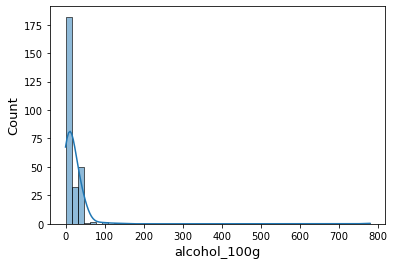

In [180]:
sns.histplot(data=openfoodfacts_not_duplicated[openfoodfacts_not_duplicated['main_category_en'] == 'alcoholic beverages'], x="alcohol_100g", kde=True, bins=50);

La distribution de la variable alcohol_100g ne suit pas une Loi Normale et n'est pas linéaire. On remarque qu'un grand nombre de produits n'en contiennent pas

In [176]:
openfoodfacts_not_duplicated[openfoodfacts_not_duplicated['main_category_en'] == 'alcoholic beverages']['alcohol_100g'].mean()

19.94834327697754